In [33]:
#!/usr/bin/env python3
"""
Complete Figure Generation Script for Advanced Materials Journal
PSNP Impact on PBMC scRNA-seq Analysis

This script generates ALL MAIN FIGURES (1-6) and ALL SUPPLEMENTARY FIGURES according to FIGURES.md specifications

"""

import logging
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Try to import upsetplot
try:
    from upsetplot import UpSet, from_contents
except ImportError:
    logging.warning("upsetplot not found, installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'upsetplot'])
    from upsetplot import UpSet, from_contents

# ============================================================
# LOGGING CONFIGURATION
# ============================================================

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

# ============================================================
# SETUP AND CONFIGURATION
# ============================================================

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Output directory
FIG_DIR = Path('./fig')
FIG_DIR.mkdir(exist_ok=True)


SAMPLE_COLORS = {
    'sample_1': '#d01c8b', '40nm': '#d01c8b',
    'sample_2': '#f1b6da', '200nm': '#f1b6da',
    'sample_3': '#b8e186', '40+200nm': '#b8e186',
    'sample_4': '#4dac26', 'Untreated': '#4dac26', 'Control': '#4dac26'
}

CELL_TYPE_COLORS = {
    'B cell': '#abd9e9',
    'CD4+ T cell': '#fdae61',
    'Cytotoxic T cell': '#2c7bb6',# '#ffffbf',
    'CD14+ monocyte': '#d7191c',
    'Natural killer cell': '#8856a7'
}

CELL_TYPE_SHORT_MAP = {
    'B cell': 'B cell',
    'CD4+ T cell': 'CD4+',
    'Cytotoxic T cell': 'CD8+',
    'CD14+ monocyte': 'Monocyte',
    'Natural killer cell': 'NK'
}

REG_COLORS = {
    'Upregulated': '#d7191c',
    'Downregulated': '#2c7bb6',
    'Not Significant': '#B0B0B0'
}

SAMPLE_NAMES = {
    'sample_1': '40nm',
    'sample_2': '200nm',
    'sample_3': '40+200nm',
    'sample_4': 'Control'
}

CELL_TYPE_ORDER = [
    'CD14+ monocyte',
    'B cell',
    'CD4+ T cell',
    'Cytotoxic T cell',
    'Natural killer cell'
]

samples = ['40nm', '200nm', '40+200nm']

logger.info("Configuration loaded")
logger.info(f"Output directory: {FIG_DIR.absolute()}")

cmap = 'RdBu_r'

# ============================================================
# LOAD DATA
# ============================================================

logger.info("Loading differential expression and pathway enrichment results...")

# Load DE results
de_results_path = Path('./results/de_results_CoDi_dist.xlsx')
de_results = {}
if de_results_path.exists():
    logger.info(f"Loading DE results from {de_results_path}")
    excel_file = pd.ExcelFile(de_results_path)
    for sheet_name in excel_file.sheet_names:
        de_results[sheet_name] = excel_file.parse(sheet_name)
    logger.info(f"✓ Loaded {len(de_results)} DE result sheets")
else:
    logger.error(f"DE results file not found: {de_results_path}")
    raise FileNotFoundError(f"Required file not found: {de_results_path}")

# Load GSE results
gse_results_path = Path('../data/Pathways_KEGG_cleaned.xlsx')
gse_results = {}
if gse_results_path.exists():
    logger.info(f"Loading GSE results from {gse_results_path}")
    gse_file = pd.ExcelFile(gse_results_path)
    for sheet_name in gse_file.sheet_names:
        gse_results[sheet_name] = gse_file.parse(sheet_name)
    logger.info(f"✓ Loaded {len(gse_results)} GSE result sheets")
else:
    logger.warning(f"GSE results file not found: {gse_results_path}")

def get_gse_sheet_name(cell_type, condition):
    """
    Convert cell type and condition to GSE sheet name format.
    GSE sheets use format: CellType_sample_X
    e.g., "Monocyte_sample_1", "B_cell_sample_2"
    """
    ct_map = {
        'B cell': 'B_cell',
        'CD4+ T cell': 'CD4+_T_cell',
        'Cytotoxic T cell': 'Cytotoxic_T_cell',
        'CD14+ monocyte': 'Monocyte',
        'Natural killer cell': 'Natural_killer_cell'
    }

    # Condition to sample mapping
    cond_map = {
        '40nm': 'sample_1',
        '200nm': 'sample_2',
        '40+200nm': 'sample_3',
    }

    ct_name = ct_map.get(cell_type, cell_type.replace(' ', '_'))
    sample_name = cond_map.get(condition, condition)
    return f"{ct_name}_{sample_name}"

# Helper function for sheet names
def get_sheet_name_fig2(cell_type, condition):
    ct_map = {
        'B cell': 'B_cell',
        'CD4+ T cell': 'CD4+_T_cell',
        'Cytotoxic T cell': 'Cytotoxic_T_cell',
        'CD14+ monocyte': 'CD14+_monocyte',
        'Natural killer cell': 'Natural_killer_cell'
    }
    cond_map = {'40nm': 'sample_1', '200nm': 'sample_2', '40+200nm': 'sample_3'}
    return f"{ct_map.get(cell_type, cell_type.replace(' ', '_'))}_{cond_map[condition]}"

11:28:50 - INFO - Configuration loaded
11:28:50 - INFO - Output directory: /Users/vladimirk/repositories/nano/notebooks/fig
11:28:50 - INFO - Loading differential expression and pathway enrichment results...
11:28:50 - INFO - Loading DE results from results/de_results_CoDi_dist.xlsx
11:28:54 - INFO - ✓ Loaded 15 DE result sheets
11:28:54 - INFO - Loading GSE results from ../data/Pathways_KEGG_cleaned.xlsx
11:28:54 - INFO - ✓ Loaded 15 GSE result sheets


# ============================================================
# FIGURE 1: Overview - scRNA-seq Experimental Setup and Global Analysis
# ============================================================

10:53:38 - INFO -   Loaded data from: ../data/merged_umap.h5ad
10:53:38 - INFO - Creating Figure 1D (Cell Composition)...
10:53:39 - INFO - ✓ Figure 1D (Cell Composition) saved as Figure_1d_composition.pdf and .png


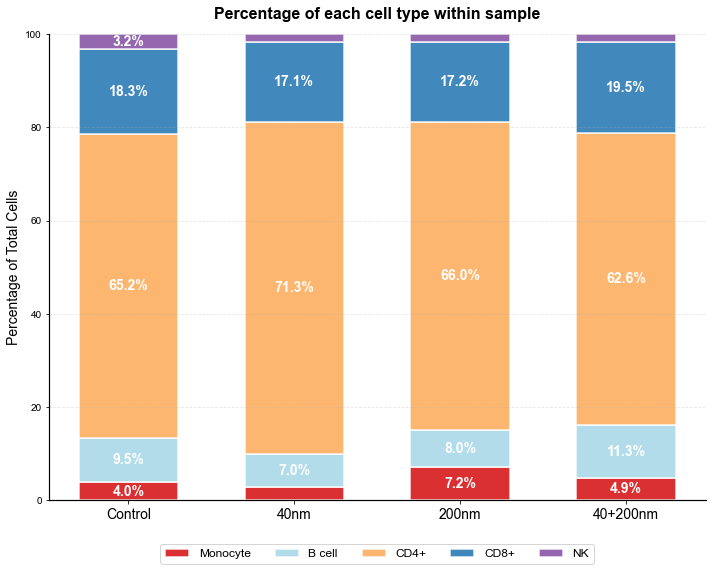

In [27]:
# ============================================================
# FIGURE 1D (Separate): Cell Composition Stacked Bar Chart
# ============================================================
cell_type_col = 'CoDi_dist'  # Use CoDi_dist annotation as specified
sample_col = 'sample'
# Load AnnData object
adata_path = '../data/merged_umap.h5ad'
adata = sc.read_h5ad(adata_path)
logger.info(f"  Loaded data from: {adata_path}")
        

if adata is None:
    raise FileNotFoundError("Could not find AnnData file")

# Build composition data (needed for separate Figure 1D/1E cells)
composition_data = []
for sample in ['sample_4', 'sample_1', 'sample_2', 'sample_3']:
    if sample in adata.obs[sample_col].values:
        sample_mask = adata.obs[sample_col] == sample
        total_cells = sample_mask.sum()
        for ct in CELL_TYPE_ORDER:
            ct_mask = adata.obs[cell_type_col] == ct
            count = (sample_mask & ct_mask).sum()
            percentage = (count / total_cells * 100) if total_cells > 0 else 0
            composition_data.append({'Condition': SAMPLE_NAMES.get(sample, sample), 'Cell Type': ct, 'Percentage': percentage, 'Count': count})

comp_df = pd.DataFrame(composition_data)

logger.info("Creating Figure 1D (Cell Composition)...")

fig1d, ax_1d_sep = plt.subplots(figsize=(10, 8))

conditions = ['Control', '40nm', '200nm', '40+200nm']
x = np.arange(len(conditions))
width = 0.6

bottom = np.zeros(len(conditions))
for ct in CELL_TYPE_ORDER:
    heights = [comp_df[(comp_df['Condition'] == cond) & (comp_df['Cell Type'] == ct)]['Percentage'].values[0]
               if len(comp_df[(comp_df['Condition'] == cond) & (comp_df['Cell Type'] == ct)]) > 0 else 0
               for cond in conditions]
    ax_1d_sep.bar(x, heights, width, bottom=bottom, label=CELL_TYPE_SHORT_MAP[ct], 
                  color=CELL_TYPE_COLORS[ct], edgecolor='white', linewidth=1.5, alpha=0.9)
    
    for i, height in enumerate(heights):
        if height > 3:
            ax_1d_sep.text(x[i], bottom[i] + height/2, f'{height:.1f}%', 
                          ha='center', va='center', fontsize=14, fontweight='bold', color='white')
    bottom += heights

ax_1d_sep.set_xticks(x)
ax_1d_sep.set_xticklabels(conditions, fontsize=14)
ax_1d_sep.set_ylabel('Percentage of Total Cells', fontsize=14)
ax_1d_sep.set_ylim(0, 100)
ax_1d_sep.set_title('Percentage of each cell type within sample', fontsize=16, fontweight='bold', pad=15)
ax_1d_sep.legend(frameon=True, fontsize=12, ncol=5, loc='upper center', bbox_to_anchor=(0.5, -0.08))
ax_1d_sep.spines['top'].set_visible(False)
ax_1d_sep.spines['right'].set_visible(False)
ax_1d_sep.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(FIG_DIR / 'Figure_1d_composition.pdf', bbox_inches='tight')
plt.savefig(FIG_DIR / 'Figure_1d_composition.png', bbox_inches='tight', dpi=300)
logger.info("✓ Figure 1D (Cell Composition) saved as Figure_1d_composition.pdf and .png")

10:54:00 - INFO - Creating Figure 1E (Transposed Cell Count Table)...
10:54:01 - INFO - ✓ Figure 1E (Transposed) saved as Figure_1e_transposed.pdf and .png


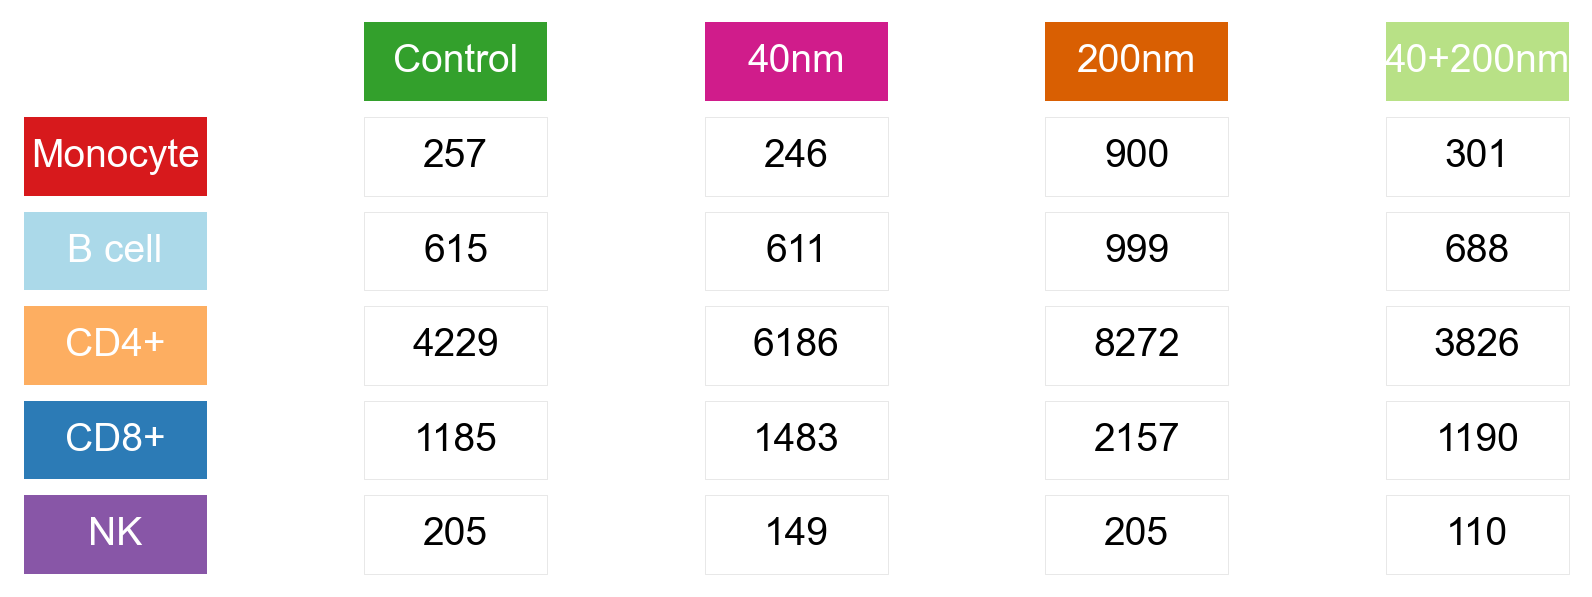

In [28]:
# ============================================================
# FIGURE 1E (Separate): Transposed Cell Count Table
# Rows = Cell Types (colored), Columns = Conditions (colored)
# With customizable spacing between columns
# ============================================================
logger.info("Creating Figure 1E (Transposed Cell Count Table)...")

# ===========================================
# ADJUSTABLE PARAMETERS
# ===========================================
COLUMN_GAP = 0.19       # Gap between columns (adjust this!)
ROW_GAP = 0.02          # Gap between rows
CELL_WIDTH = 0.22       # Width of each cell
CELL_HEIGHT = 0.1      # Height of each cell
ROW_LABEL_WIDTH = 0.22  # Width of row label column
FONT_SIZE = 39          # Font size for cell text
# ===========================================

# Create transposed cell count table data: rows = cell types, columns = conditions
conditions = ['Control', '40nm', '200nm', '40+200nm']
table_data_transposed = []
for ct in CELL_TYPE_ORDER:
    row = []
    for cond in conditions:
        count = comp_df[(comp_df['Condition'] == cond) & (comp_df['Cell Type'] == ct)]['Count'].values
        row.append(int(count[0]) if len(count) > 0 else 0)
    table_data_transposed.append(row)

# Row labels = cell types (short names)
row_labels = [CELL_TYPE_SHORT_MAP.get(ct, ct) for ct in CELL_TYPE_ORDER]

# Condition colors for column headers
CONDITION_COLORS = {
    'Control': '#33a02c',
    '40nm': '#d01c8b',
    '200nm': '#d95f02',
    '40+200nm': '#b8e186'
}

n_rows = len(CELL_TYPE_ORDER)
n_cols = len(conditions)

# Calculate total width and height
total_width = ROW_LABEL_WIDTH + COLUMN_GAP + n_cols * CELL_WIDTH + (n_cols - 1) * COLUMN_GAP
total_height = (n_rows + 1) * CELL_HEIGHT + n_rows * ROW_GAP  # +1 for header

# Create figure with size proportional to content
fig_width = total_width * 12  # Scale factor for figure size
fig_height = total_height * 12
fig1e, ax1e = plt.subplots(figsize=(fig_width, fig_height))
ax1e.axis('off')

# Starting positions
start_x = 0
start_y = total_height

# Draw column headers (conditions)
for j, cond in enumerate(conditions):
    x = start_x + ROW_LABEL_WIDTH + COLUMN_GAP + j * (CELL_WIDTH + COLUMN_GAP)
    y = start_y - CELL_HEIGHT
    
    rect = plt.Rectangle((x, y), CELL_WIDTH, CELL_HEIGHT, 
                          facecolor=CONDITION_COLORS[cond], edgecolor='none')
    ax1e.add_patch(rect)
    ax1e.text(x + CELL_WIDTH/2, y + CELL_HEIGHT/2, cond, 
              ha='center', va='center', fontsize=FONT_SIZE, color='white') # fontweight='bold', 

# Draw row labels and data cells
for i, ct in enumerate(CELL_TYPE_ORDER):
    y = start_y - (i + 2) * CELL_HEIGHT - (i + 1) * ROW_GAP
    
    # Row label (cell type)
    rect = plt.Rectangle((start_x, y), ROW_LABEL_WIDTH, CELL_HEIGHT,
                          facecolor=CELL_TYPE_COLORS[ct], edgecolor='none')
    ax1e.add_patch(rect)
    ax1e.text(start_x + ROW_LABEL_WIDTH/2, y + CELL_HEIGHT/2, row_labels[i],
              ha='center', va='center', fontsize=FONT_SIZE, color='white') #  fontweight='bold',
    
    # Data cells
    for j, cond in enumerate(conditions):
        x = start_x + ROW_LABEL_WIDTH + COLUMN_GAP + j * (CELL_WIDTH + COLUMN_GAP)
        
        rect = plt.Rectangle((x, y), CELL_WIDTH, CELL_HEIGHT,
                              facecolor='white', edgecolor='lightgray', linewidth=0.5)
        ax1e.add_patch(rect)
        ax1e.text(x + CELL_WIDTH/2, y + CELL_HEIGHT/2, str(table_data_transposed[i][j]),
                  ha='center', va='center', fontsize=FONT_SIZE)

# Set axis limits based on actual content with small padding
padding = 0.02
ax1e.set_xlim(-padding, total_width + padding)
ax1e.set_ylim(-padding, total_height + padding)

# ax1e.set_title('e) Cell Counts by Cell Type and Condition', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(FIG_DIR / 'Figure_1e_transposed.pdf', bbox_inches='tight')
plt.savefig(FIG_DIR / 'Figure_1e_transposed.png', bbox_inches='tight', dpi=300)
logger.info("✓ Figure 1E (Transposed) saved as Figure_1e_transposed.pdf and .png")

10:54:21 - INFO -   Panel 1C: UMAP by cell type...


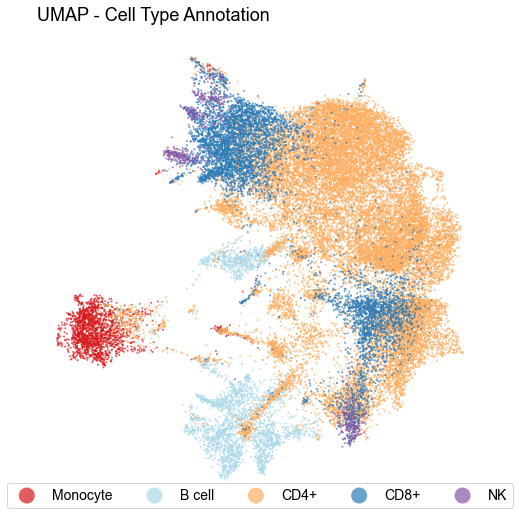

In [29]:
# Load AnnData object
# path = '../data/merged_umap.h5ad'
# adata = sc.read_h5ad(path)
# logger.info(f"  Loaded data from: {path}")
        
# Panel 1C: UMAP by cell type
logger.info("  Panel 1C: UMAP by cell type...")

fig, ax_1c = plt.subplots(figsize=(8, 14))
umap_coords = adata.obsm['X_umap_after']

for ct in CELL_TYPE_ORDER:
    mask = adata.obs[cell_type_col] == ct
    if mask.sum() > 0:
        ax_1c.scatter(umap_coords[mask, 0], umap_coords[mask, 1],
                     c=CELL_TYPE_COLORS[ct], label=CELL_TYPE_SHORT_MAP[ct], s=4, alpha=0.7, edgecolors='none', rasterized=True)

ax_1c.set_xlabel(None)
ax_1c.set_ylabel(None)
ax_1c.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

ax_1c.set_title('UMAP - Cell Type Annotation',
               fontsize=18, loc='left', pad=15)
ax_1c.legend(frameon=True, fontsize=14, loc='lower center', markerscale=8, ncols=5, bbox_to_anchor=(0.5, -0.03))
ax_1c.spines['top'].set_visible(False)
ax_1c.spines['right'].set_visible(False)
ax_1c.spines['bottom'].set_visible(False)
ax_1c.spines['left'].set_visible(False)
ax_1c.set_aspect('equal', 'box')
plt.savefig(FIG_DIR / 'Figure_1b_umap.png', bbox_inches='tight', dpi=300)


# ============================================================
# FIGURE 2: Size-dependent Transcriptional Impact
# ============================================================

10:19:46 - INFO - Creating Complete Figure 2...
10:19:46 - INFO -   Panel 2A: DEG Burden...
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_23462/1899347478.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_2a.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
10:19:46 - INFO -   Panel 2B: DEG Density normalized to cell abundance...
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_23462/1899347478.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_2b.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
10:20:01 - INFO -   Panel 2C: Directionality...
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_23462/1899347478.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after 

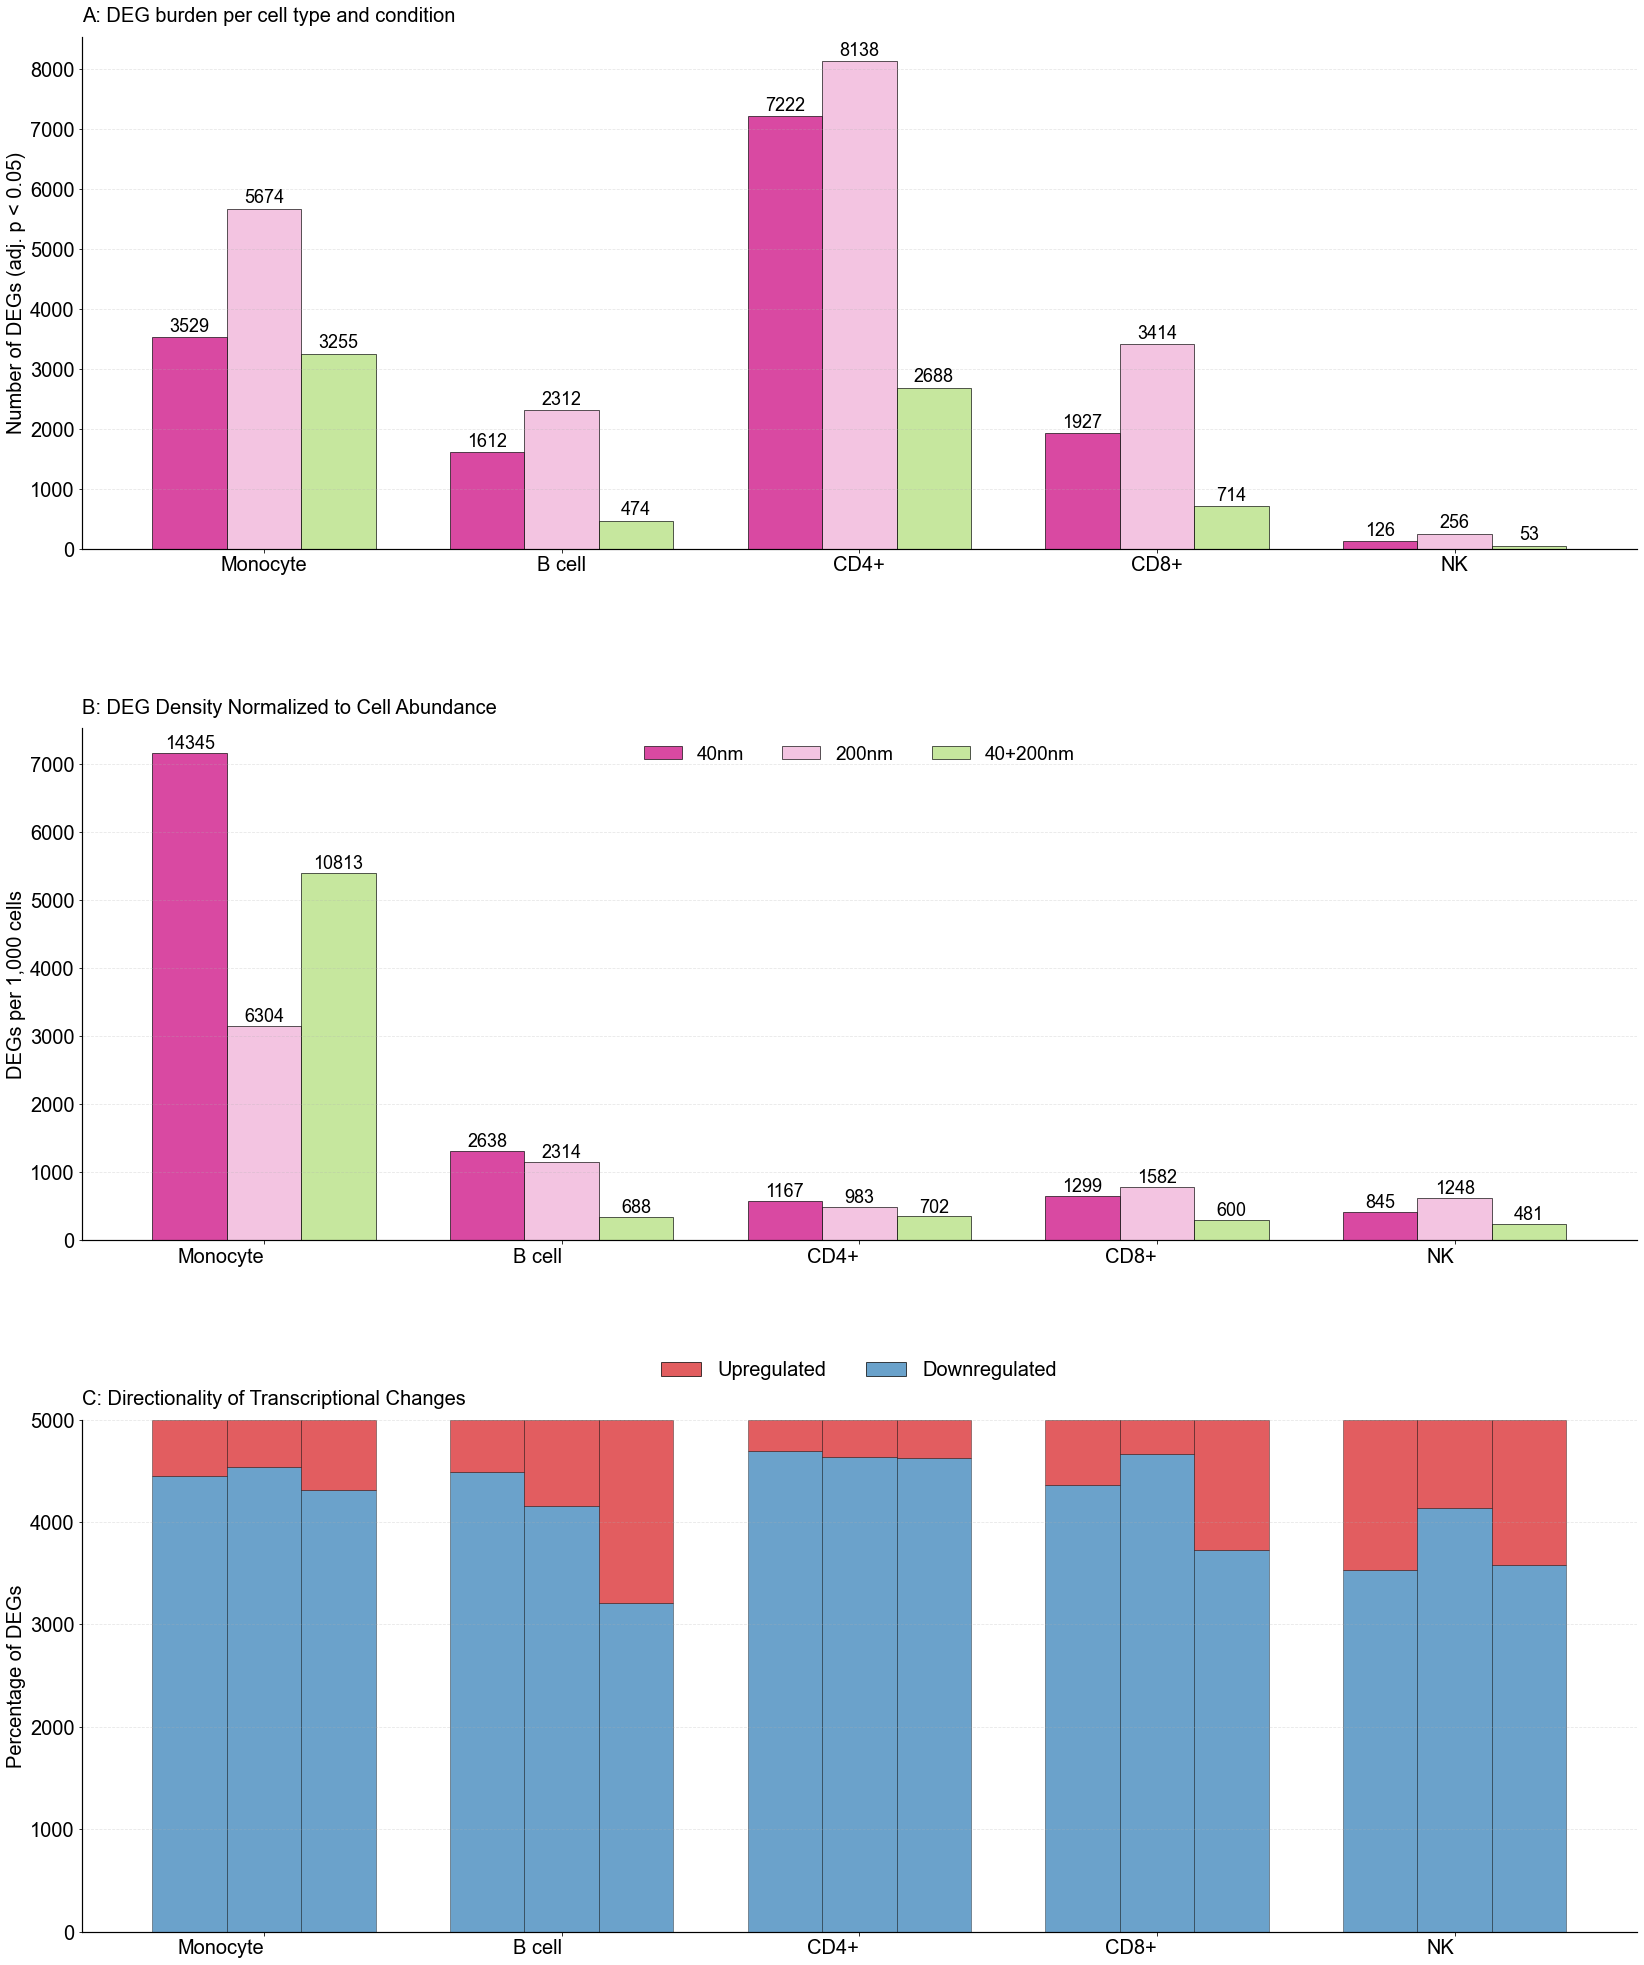

In [3]:
"""
FIGURE 2: Complete - Size-dependent transcriptional impact of PSNP exposure
Updated: 2026-01-08
- Panel 2A: DEG burden per cell type and experimental condition
- Panel 2B: DEG burden normalized to cell abundance (DEG density per 1,000 cells)
- Panel 2C: Directionality of transcriptional changes  
- Panel 2D: Full volcano plots (all cell types × all conditions)
"""
logger.info("Creating Complete Figure 2...")

from matplotlib.gridspec import GridSpec

# Create figure with complex layout
fig = plt.figure(figsize=(24, 28))
gs = GridSpec(3, 1, figure=fig, hspace=0.35, height_ratios=[1, 1, 1],
              left=0.08, right=0.98, top=0.97, bottom=0.03)


# ============================================================
# Panel 2A: DEG Burden per Cell Type
# ============================================================
logger.info("  Panel 2A: DEG Burden...")
ax_2a = fig.add_subplot(gs[0])

deg_data = []
for sample in samples:
    for ct in CELL_TYPE_ORDER:
        sheet_name = get_sheet_name_fig2(ct, sample)
        if sheet_name in de_results:
            n_degs = len(de_results[sheet_name][de_results[sheet_name]['pvals_adj'] < 0.05])
            deg_data.append({'Cell Type': ct, 'Sample': sample, 'DEGs': n_degs})

deg_df = pd.DataFrame(deg_data)
x = np.arange(len(CELL_TYPE_ORDER))
width = 0.25

for i, sample in enumerate(samples):
    sample_data = deg_df[deg_df['Sample'] == sample]
    heights = [sample_data[sample_data['Cell Type'] == ct]['DEGs'].values[0]
               if len(sample_data[sample_data['Cell Type'] == ct]) > 0 else 0
               for ct in CELL_TYPE_ORDER]
    
    bars = ax_2a.bar(x + i*width - width, heights, width, label=sample,
                     color=SAMPLE_COLORS[sample], edgecolor='black', linewidth=0.8, alpha=0.8)
    
    for bar, height in zip(bars, heights):
        if height > 0:
            ax_2a.text(bar.get_x() + bar.get_width()/2, height + 30,
                      str(int(height)), ha='center', va='bottom', fontsize=18)

ax_2a.set_xticks(x)
ax_2a.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=0, ha='center', fontsize=20)
ax_2a.set_ylabel('Number of DEGs (adj. p < 0.05)', fontsize=20)
ax_2a.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
ax_2a.set_title('A: DEG burden per cell type and condition',
               fontsize=20, loc='left', pad=15)
ax_2a.spines['top'].set_visible(False)
ax_2a.spines['right'].set_visible(False)
ax_2a.grid(axis='y', alpha=0.3, linestyle='--')

# ============================================================
# Panel 2B: DEG Density (DEGs per 1,000 cells)
# ============================================================
logger.info("  Panel 2B: DEG Density normalized to cell abundance...")
ax_2b = fig.add_subplot(gs[1])

# Load cell counts
try:
    import scanpy as sc
    adata = sc.read_h5ad('../data/merged.h5ad')
    cell_counts = {}
    for sample_num, sample_name in [(1, '40nm'), (2, '200nm'), (3, '40+200nm')]:
        sample_mask = adata.obs['sample'] == f'sample_{sample_num}'
        for ct in CELL_TYPE_ORDER:
            ct_mask = adata.obs['CoDi_dist'] == ct
            count = (sample_mask & ct_mask).sum()
            cell_counts[(ct, sample_name)] = count
except Exception as e:
    logger.warning(f"  Error calculating cell counts: {e}")
    assert f"Error calculating cell counts: {e}"

# Calculate DEG density
density_data = []
for sample_name in samples:
    for ct in CELL_TYPE_ORDER:
        deg_count = deg_df[(deg_df['Cell Type'] == ct) & (deg_df['Sample'] == sample_name)]['DEGs'].values
        deg_count = deg_count[0] if len(deg_count) > 0 else 0
        n_cells = cell_counts.get((ct, sample_name), 1)
        deg_density = (deg_count / n_cells) * 1000 if n_cells > 0 else 0
        density_data.append({'Cell Type': ct, 'Sample': sample_name, 'DEG Density': deg_density})

density_df = pd.DataFrame(density_data)

# Plot
for i, sample in enumerate(samples):
    sample_data = density_df[density_df['Sample'] == sample]
    heights = [sample_data[sample_data['Cell Type'] == ct]['DEG Density'].values[0]
               if len(sample_data[sample_data['Cell Type'] == ct]) > 0 else 0
               for ct in CELL_TYPE_ORDER]
    bars = ax_2b.bar(x + i*width - width, heights, width, label=sample,
                     color=SAMPLE_COLORS[sample], edgecolor='black', linewidth=0.8, alpha=0.8)
    
    for bar, height in zip(bars, heights):
        if height > 0:
            ax_2b.text(bar.get_x() + bar.get_width()/2, height + 10,
                      f'{int(height)}', ha='center', va='bottom', fontsize=18)

ax_2b.set_xticks(x)
ax_2b.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=0, ha='right', fontsize=20)
ax_2b.set_ylabel('DEGs per 1,000 cells', fontsize=20)
ax_2b.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
ax_2b.set_title('B: DEG Density Normalized to Cell Abundance',
               fontsize=20, loc='left', pad=15)
ax_2b.legend(frameon=False, fontsize=19, ncol=4, loc='upper center')
ax_2b.spines['top'].set_visible(False)
ax_2b.spines['right'].set_visible(False)
ax_2b.grid(axis='y', alpha=0.3, linestyle='--')

# ============================================================
# Panel 2C: Directionality
# ============================================================
logger.info("  Panel 2C: Directionality...")
ax_2c = fig.add_subplot(gs[2])

direction_data = []
for sample in samples:
    for ct in CELL_TYPE_ORDER:
        sheet_name = get_sheet_name_fig2(ct, sample)
        if sheet_name in de_results:
            df = de_results[sheet_name]
            sig_df = df[df['pvals_adj'] < 0.05]
            n_up = len(sig_df[sig_df['logfoldchanges'] > 0])
            n_down = len(sig_df[sig_df['logfoldchanges'] < 0])
            total = n_up + n_down
            if total > 0:
                direction_data.append({
                    'Cell Type': ct, 'Sample': sample,
                    'Up %': (n_up / total) * 100, 'Down %': (n_down / total) * 100
                })

dir_df = pd.DataFrame(direction_data)

for i, sample in enumerate(samples):
    sample_data = dir_df[dir_df['Sample'] == sample]
    up_vals = [sample_data[sample_data['Cell Type'] == ct]['Up %'].values[0]
               if len(sample_data[sample_data['Cell Type'] == ct]) > 0 else 0
               for ct in CELL_TYPE_ORDER]
    down_vals = [sample_data[sample_data['Cell Type'] == ct]['Down %'].values[0]
                 if len(sample_data[sample_data['Cell Type'] == ct]) > 0 else 0
                 for ct in CELL_TYPE_ORDER]
    pos = x + i*width - width
    ax_2c.bar(pos, down_vals, width, color=REG_COLORS['Downregulated'], 
             edgecolor='black', linewidth=0.5, alpha=0.7)
    ax_2c.bar(pos, up_vals, width, bottom=down_vals, color=REG_COLORS['Upregulated'],
             edgecolor='black', linewidth=0.5, alpha=0.7)

ax_2c.set_xticks(x)
ax_2c.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=0, ha='right', fontsize=20)
ax_2c.set_ylabel('Percentage of DEGs', fontsize=20)
ax_2c.set_yticklabels([label.get_text() for label in ax_2a.get_yticklabels()], fontsize=20)
ax_2c.set_title('C: Directionality of Transcriptional Changes',
               fontsize=20, loc='left', pad=15)
ax_2c.set_ylim(0, 100)
ax_2c.spines['top'].set_visible(False)
ax_2c.spines['right'].set_visible(False)
ax_2c.grid(axis='y', alpha=0.3, linestyle='--')


ax_2c.legend(
    handles=[
        Patch(facecolor=REG_COLORS['Upregulated'], label='Upregulated',
              edgecolor='black', alpha=0.7),
        Patch(facecolor=REG_COLORS['Downregulated'], label='Downregulated',
              edgecolor='black', alpha=0.7)
    ],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),   # ⬅ above the plot
    ncol=2,                        # side-by-side
    fontsize=20,
    frameon=False
)

# Save
plt.savefig(FIG_DIR / 'Figure_2_complete.pdf', bbox_inches='tight')
logger.info("✓ Figure 2 complete\n")

# ============================================================
# FIGURE 3: 40nm PSNPs - Dominant Transcriptional Programs
# ============================================================

11:28:56 - INFO - Creating Figure 3...
11:28:56 - INFO -   Panel 3A: KEGG pathways heatmap...
11:28:57 - INFO -   Panel 3B: Gene expression heatmap...
11:28:58 - INFO - ✓ Figure 3 complete



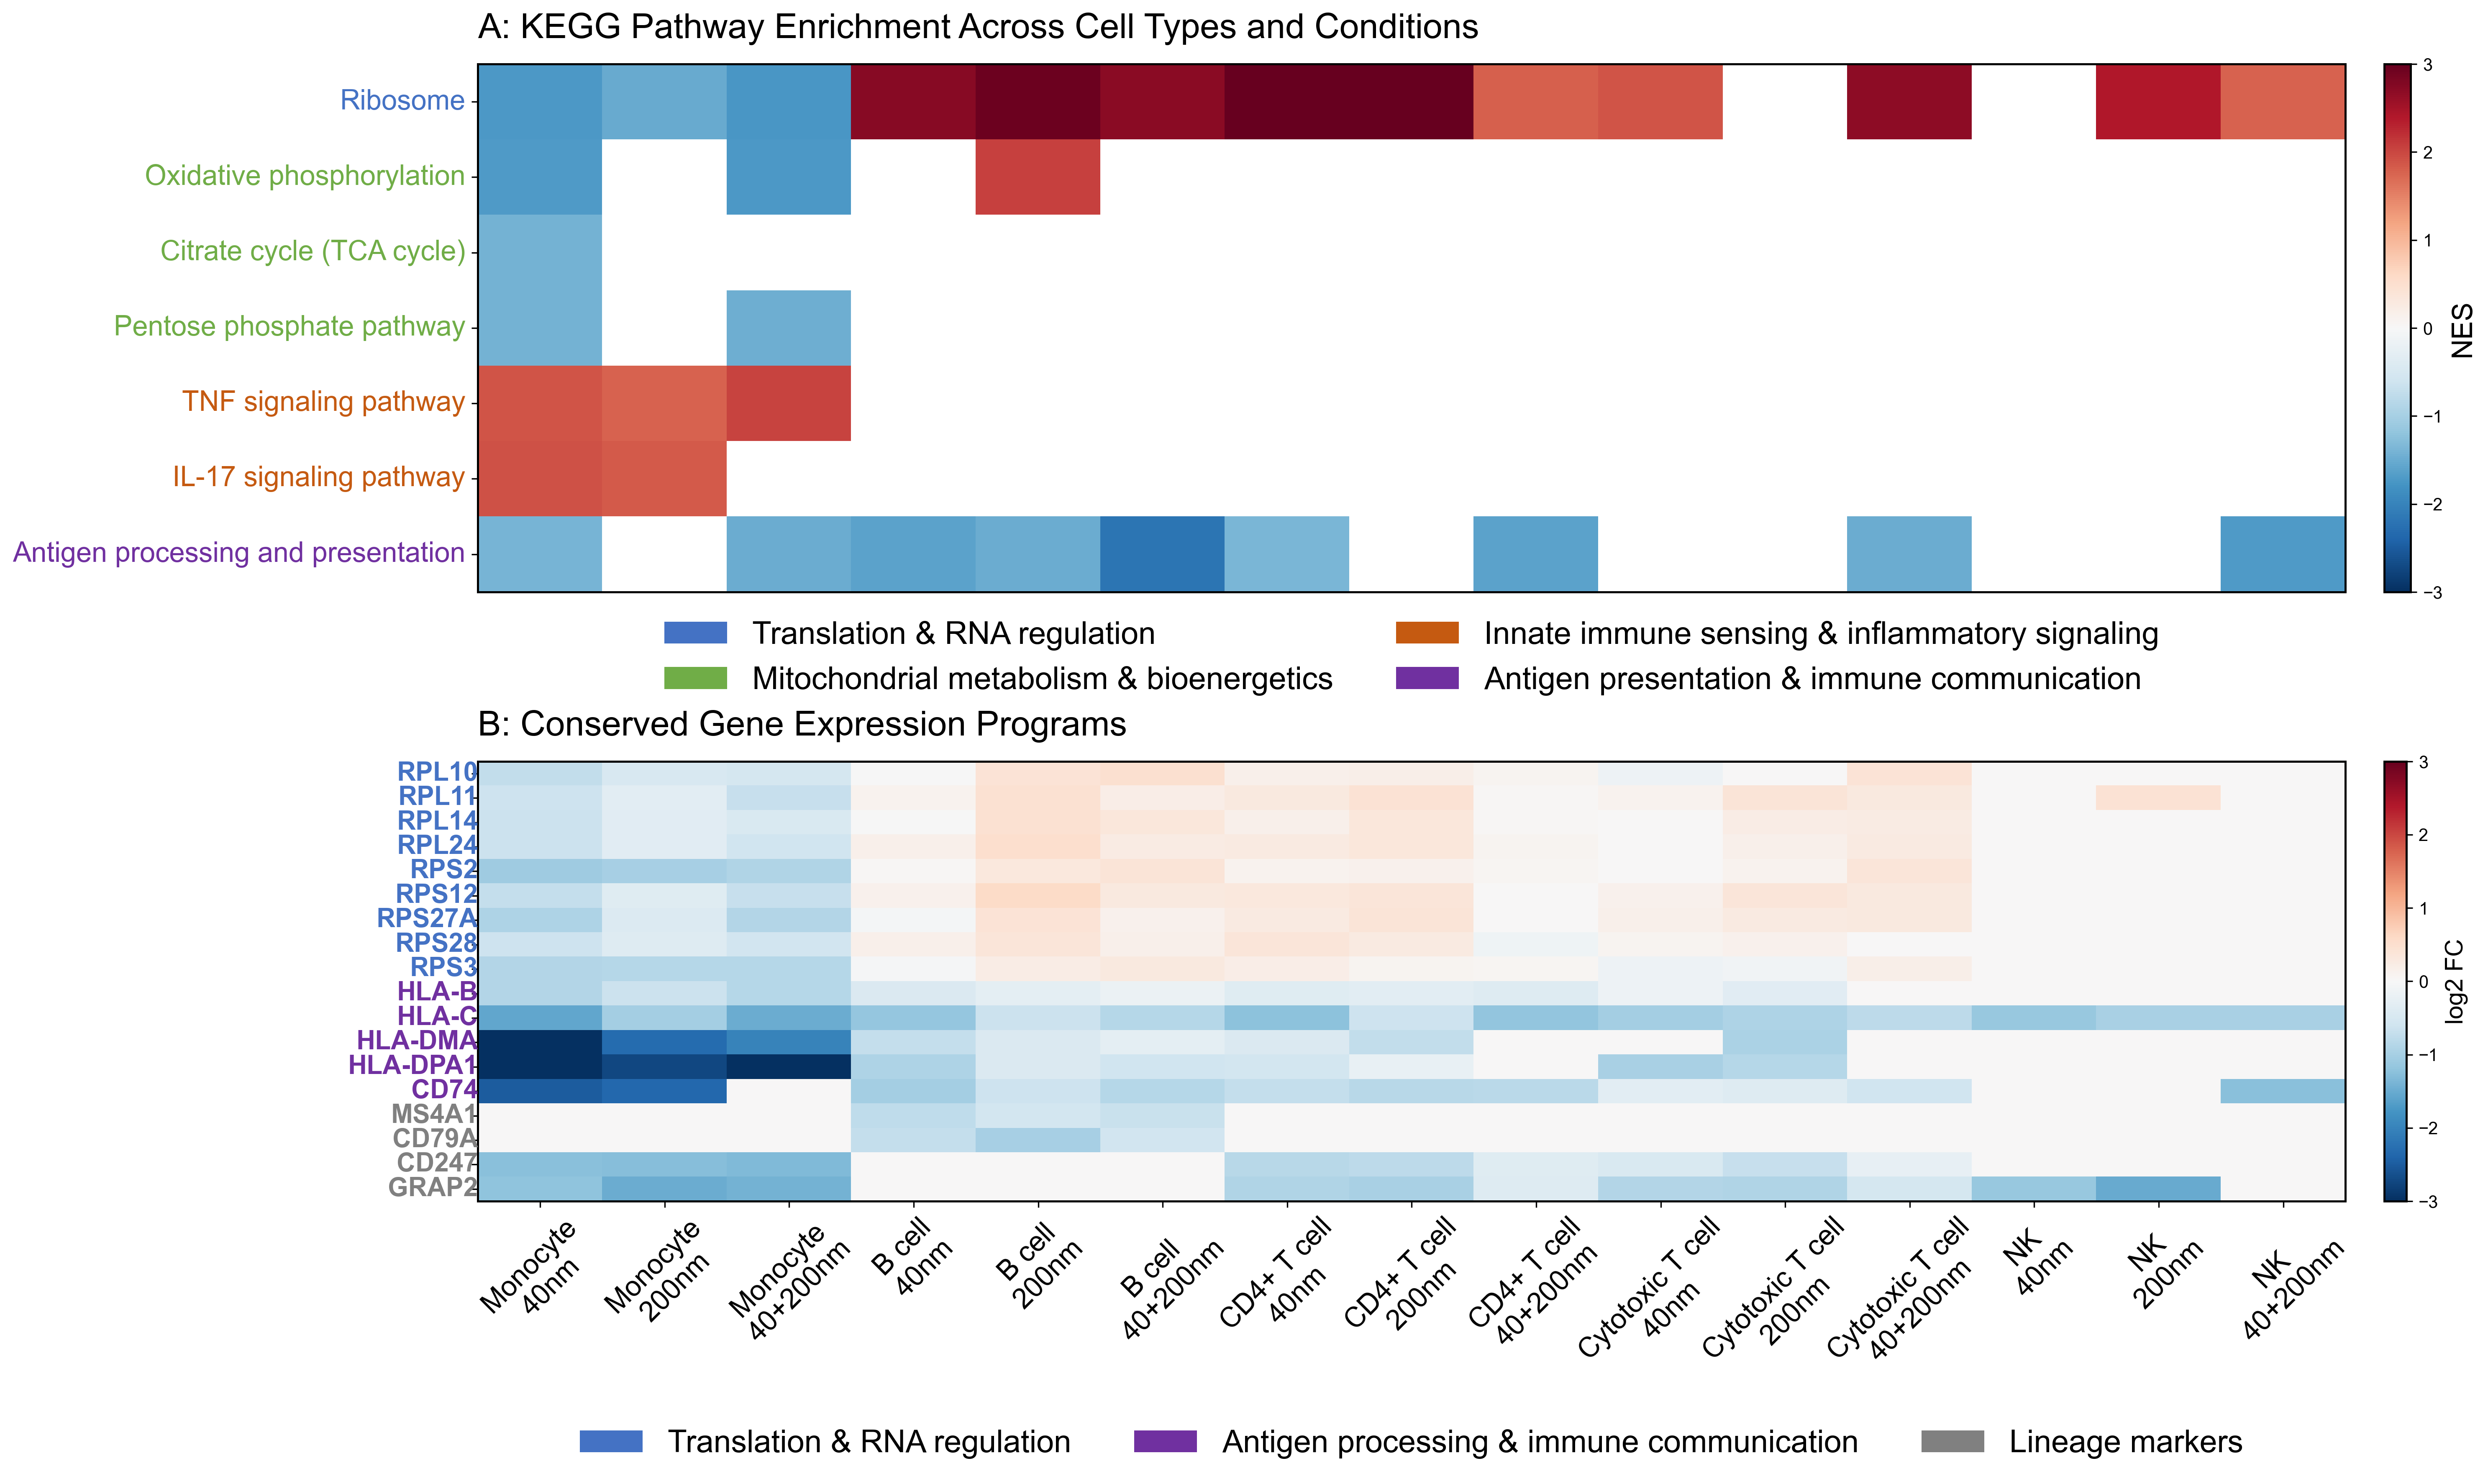

In [34]:
"""
FIGURE 3: Conserved transcriptional programs induced by PSNP exposure
- Panel 3A: KEGG pathways heatmap (Pathway × Cell type × condition)
- Panel 3B: Gene expression heatmap showing conserved programs
"""
logger.info("Creating Figure 3...")

# ============================================================
# Panel 3A: KEGG Pathways Heatmap
# ============================================================
logger.info("  Panel 3A: KEGG pathways heatmap...")

# Define pathways and their groups
pathway_groups = {
    'Translation & RNA regulation': {
        'color': '#4472C4',
        'pathways': ['Ribosome']
    },
    'Mitochondrial metabolism & bioenergetics': {
        'color': '#70AD47',
        'pathways': [
            'Oxidative phosphorylation',
            'Citrate cycle (TCA cycle)',
            'Pentose phosphate pathway'
        ]
    },
    'Innate immune sensing & inflammatory signaling': {
        'color': '#C55A11',
        'pathways': [
            'TNF signaling pathway',
            'IL-17 signaling pathway'
        ]
    },
    'Antigen presentation & immune communication': {
        'color': '#7030A0',
        'pathways': ['Antigen processing and presentation']
    }
}

# Flatten pathway list with colors
pathway_list = []
pathway_colors_dict = {}
for group_name, group_data in pathway_groups.items():
    for pathway in group_data['pathways']:
        pathway_list.append(pathway)
        pathway_colors_dict[pathway] = group_data['color']

# Build NES matrix
nes_data = []
cell_conditions = []

for ct in CELL_TYPE_ORDER:
    for sample in samples:
        ct_map = {
            'B cell': 'Bcell',
            'CD4+ T cell': 'CD4+Tcell',
            'Cytotoxic T cell': 'CytotoxicTcell',
            'CD14+ monocyte': 'CD14+monocyte',
            'Natural killer cell': 'Naturalkillercell'
        }
        cond_map = {'40nm': 'sample_1', '200nm': 'sample_2', '40+200nm': 'sample_3'}
        
        sheet_name = get_gse_sheet_name(ct, sample)
        cell_cond_label = f"{ct.replace('CD14+ monocyte', 'Monocyte').replace('Natural killer cell', 'NK')}\n{sample}"
        cell_conditions.append(cell_cond_label)
        
        nes_values = []
        if sheet_name in gse_results:
            df = gse_results[sheet_name]
            for pathway in pathway_list:
                term_col = 'KEGG Term' if 'KEGG Term' in df.columns else 'Term'
                matches = df[df[term_col] == pathway]
                if len(matches) == 0:
                    matches = df[df[term_col].str.contains(pathway, case=False, na=False, regex=False)]
                if len(matches) > 0:
                    nes = matches.iloc[0]['NES']
                    nes_values.append(nes)
                else:
                    nes_values.append(np.nan)
        else:
            nes_values = [np.nan] * len(pathway_list)
        
        nes_data.append(nes_values)

nes_matrix = np.array(nes_data).T  # Transpose: pathways × cell_conditions

# Create Figure 3
fig3 = plt.figure(figsize=(20, 12))
gs3 = fig3.add_gridspec(2, 1, hspace=0.35, height_ratios=[1.2, 1])

# Panel 3A: Heatmap
ax_3a = fig3.add_subplot(gs3[0])

# Plot heatmap
im = ax_3a.imshow(nes_matrix, cmap=cmap, aspect='auto', vmin=-3, vmax=3)

# Add pathway labels with colors
ax_3a.set_yticks(range(len(pathway_list)))
ytick_labels = []
for i, pathway in enumerate(pathway_list):
    label = ax_3a.text(-0.6, i, f'{pathway}', va='center', ha='right',
                       fontsize=16, color=pathway_colors_dict[pathway])
    ytick_labels.append('')
ax_3a.set_yticklabels(ytick_labels)

# Add cell type/condition labels
ax_3a.set_xticks([])#range(len(cell_conditions)))
ax_3a.set_xticklabels([]) #cell_conditions, rotation=45, ha='center', fontsize=16)

# Colorbar
cbar = plt.colorbar(im, ax=ax_3a, fraction=0.02, pad=0.02)
cbar.set_label('NES', fontsize=16)

ax_3a.set_title('A: KEGG Pathway Enrichment Across Cell Types and Conditions',
               fontsize=20, loc='left', pad=15)

# Add legend for pathway groups
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=group_data['color'], label=group_name)
                   for group_name, group_data in pathway_groups.items()]
ax_3a.legend(handles=legend_elements, loc='lower center', 
             fontsize=18, frameon=False,
             bbox_to_anchor=(0.5, -0.25),   # ⬅ below the plot
             ncol=2)                        # side-by-side)

# ============================================================
# Panel 3B: Gene Expression Heatmap (Conserved Programs)
# ============================================================
logger.info("  Panel 3B: Gene expression heatmap...")

# Define gene blocks
gene_blocks = {
    'Translation & RNA regulation': {
        'genes': ['RPL10', 'RPL11', 'RPL14', 'RPL24', 'RPS2', 'RPS12', 'RPS27A', 'RPS28', 'RPS3'],
        'color': '#4472C4'
    },
    'Antigen processing & immune communication': {
        'genes': ['HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DPA1', 'CD74'],
        'color': '#7030A0'
    },
    'Lineage markers': {
        'genes': ['MS4A1', 'CD79A', 'CD247', 'GRAP2'],
        'color': '#808080'
    }
}

# Get log2FC values
ax_3b = fig3.add_subplot(gs3[1])

gene_list = []
gene_colors_list = []
for block_name, block_data in gene_blocks.items():
    gene_list.extend(block_data['genes'])
    gene_colors_list.extend([block_data['color']] * len(block_data['genes']))

# Build log2FC matrix
log2fc_data = []
for gene in gene_list:
    fc_values = []
    for ct in CELL_TYPE_ORDER:
        for sample in samples:
            sheet_name = get_sheet_name_fig2(ct, sample)
            if sheet_name in de_results:
                df = de_results[sheet_name]
                gene_data = df[df['names'] == gene]
                if len(gene_data) > 0:
                    fc_values.append(gene_data.iloc[0]['logfoldchanges'])
                else:
                    fc_values.append(0)
            else:
                fc_values.append(0)
    log2fc_data.append(fc_values)

log2fc_matrix = np.array(log2fc_data)

# Plot dot plot style
im2 = ax_3b.imshow(log2fc_matrix, cmap=cmap, aspect='auto', vmin=-3, vmax=3)

# Gene labels with colors
ax_3b.set_yticks(range(len(gene_list)))
for i, (gene, color) in enumerate(zip(gene_list, gene_colors_list)):
    ax_3b.text(-0.5, i, gene, va='center', ha='right', fontsize=15,
              color=color, fontweight='bold')
ax_3b.set_yticklabels([])

# Cell type/condition labels
ax_3b.set_xticks(range(len(cell_conditions)))
ax_3b.set_xticklabels(cell_conditions, rotation=45, ha='center', fontsize=16)

# Colorbar
cbar2 = plt.colorbar(im2, ax=ax_3b, fraction=0.02, pad=0.02)
cbar2.set_label('log2 FC', fontsize=14)

ax_3b.set_title('B: Conserved Gene Expression Programs',
               fontsize=20, loc='left', pad=15)

# Add block legend
legend_elements2 = [Patch(facecolor=block_data['color'], label=block_name)
                    for block_name, block_data in gene_blocks.items()]
ax_3b.legend(handles=legend_elements2, loc='lower center',
             fontsize=18, frameon=False,
             bbox_to_anchor=(0.5, -0.65),   # ⬅ below the plot
             ncol=3)

plt.savefig(FIG_DIR / 'Figure_3_conserved_programs.pdf', bbox_inches='tight')
logger.info("✓ Figure 3 complete\n")

# ============================================================
# FIGURE 4: 200nm PSNPs - Broad Transcriptional Perturbation
# ============================================================

13:06:23 - INFO - Creating Figure 4...
13:06:23 - INFO -   Panel 4A: Monocyte volcano plots...
13:06:23 - INFO -   Panel 4B: Module-based gene heatmap...
13:06:23 - INFO -   Panel 4C: Pathway coherence dot plot...
13:06:26 - INFO - ✓ Figure 4 complete



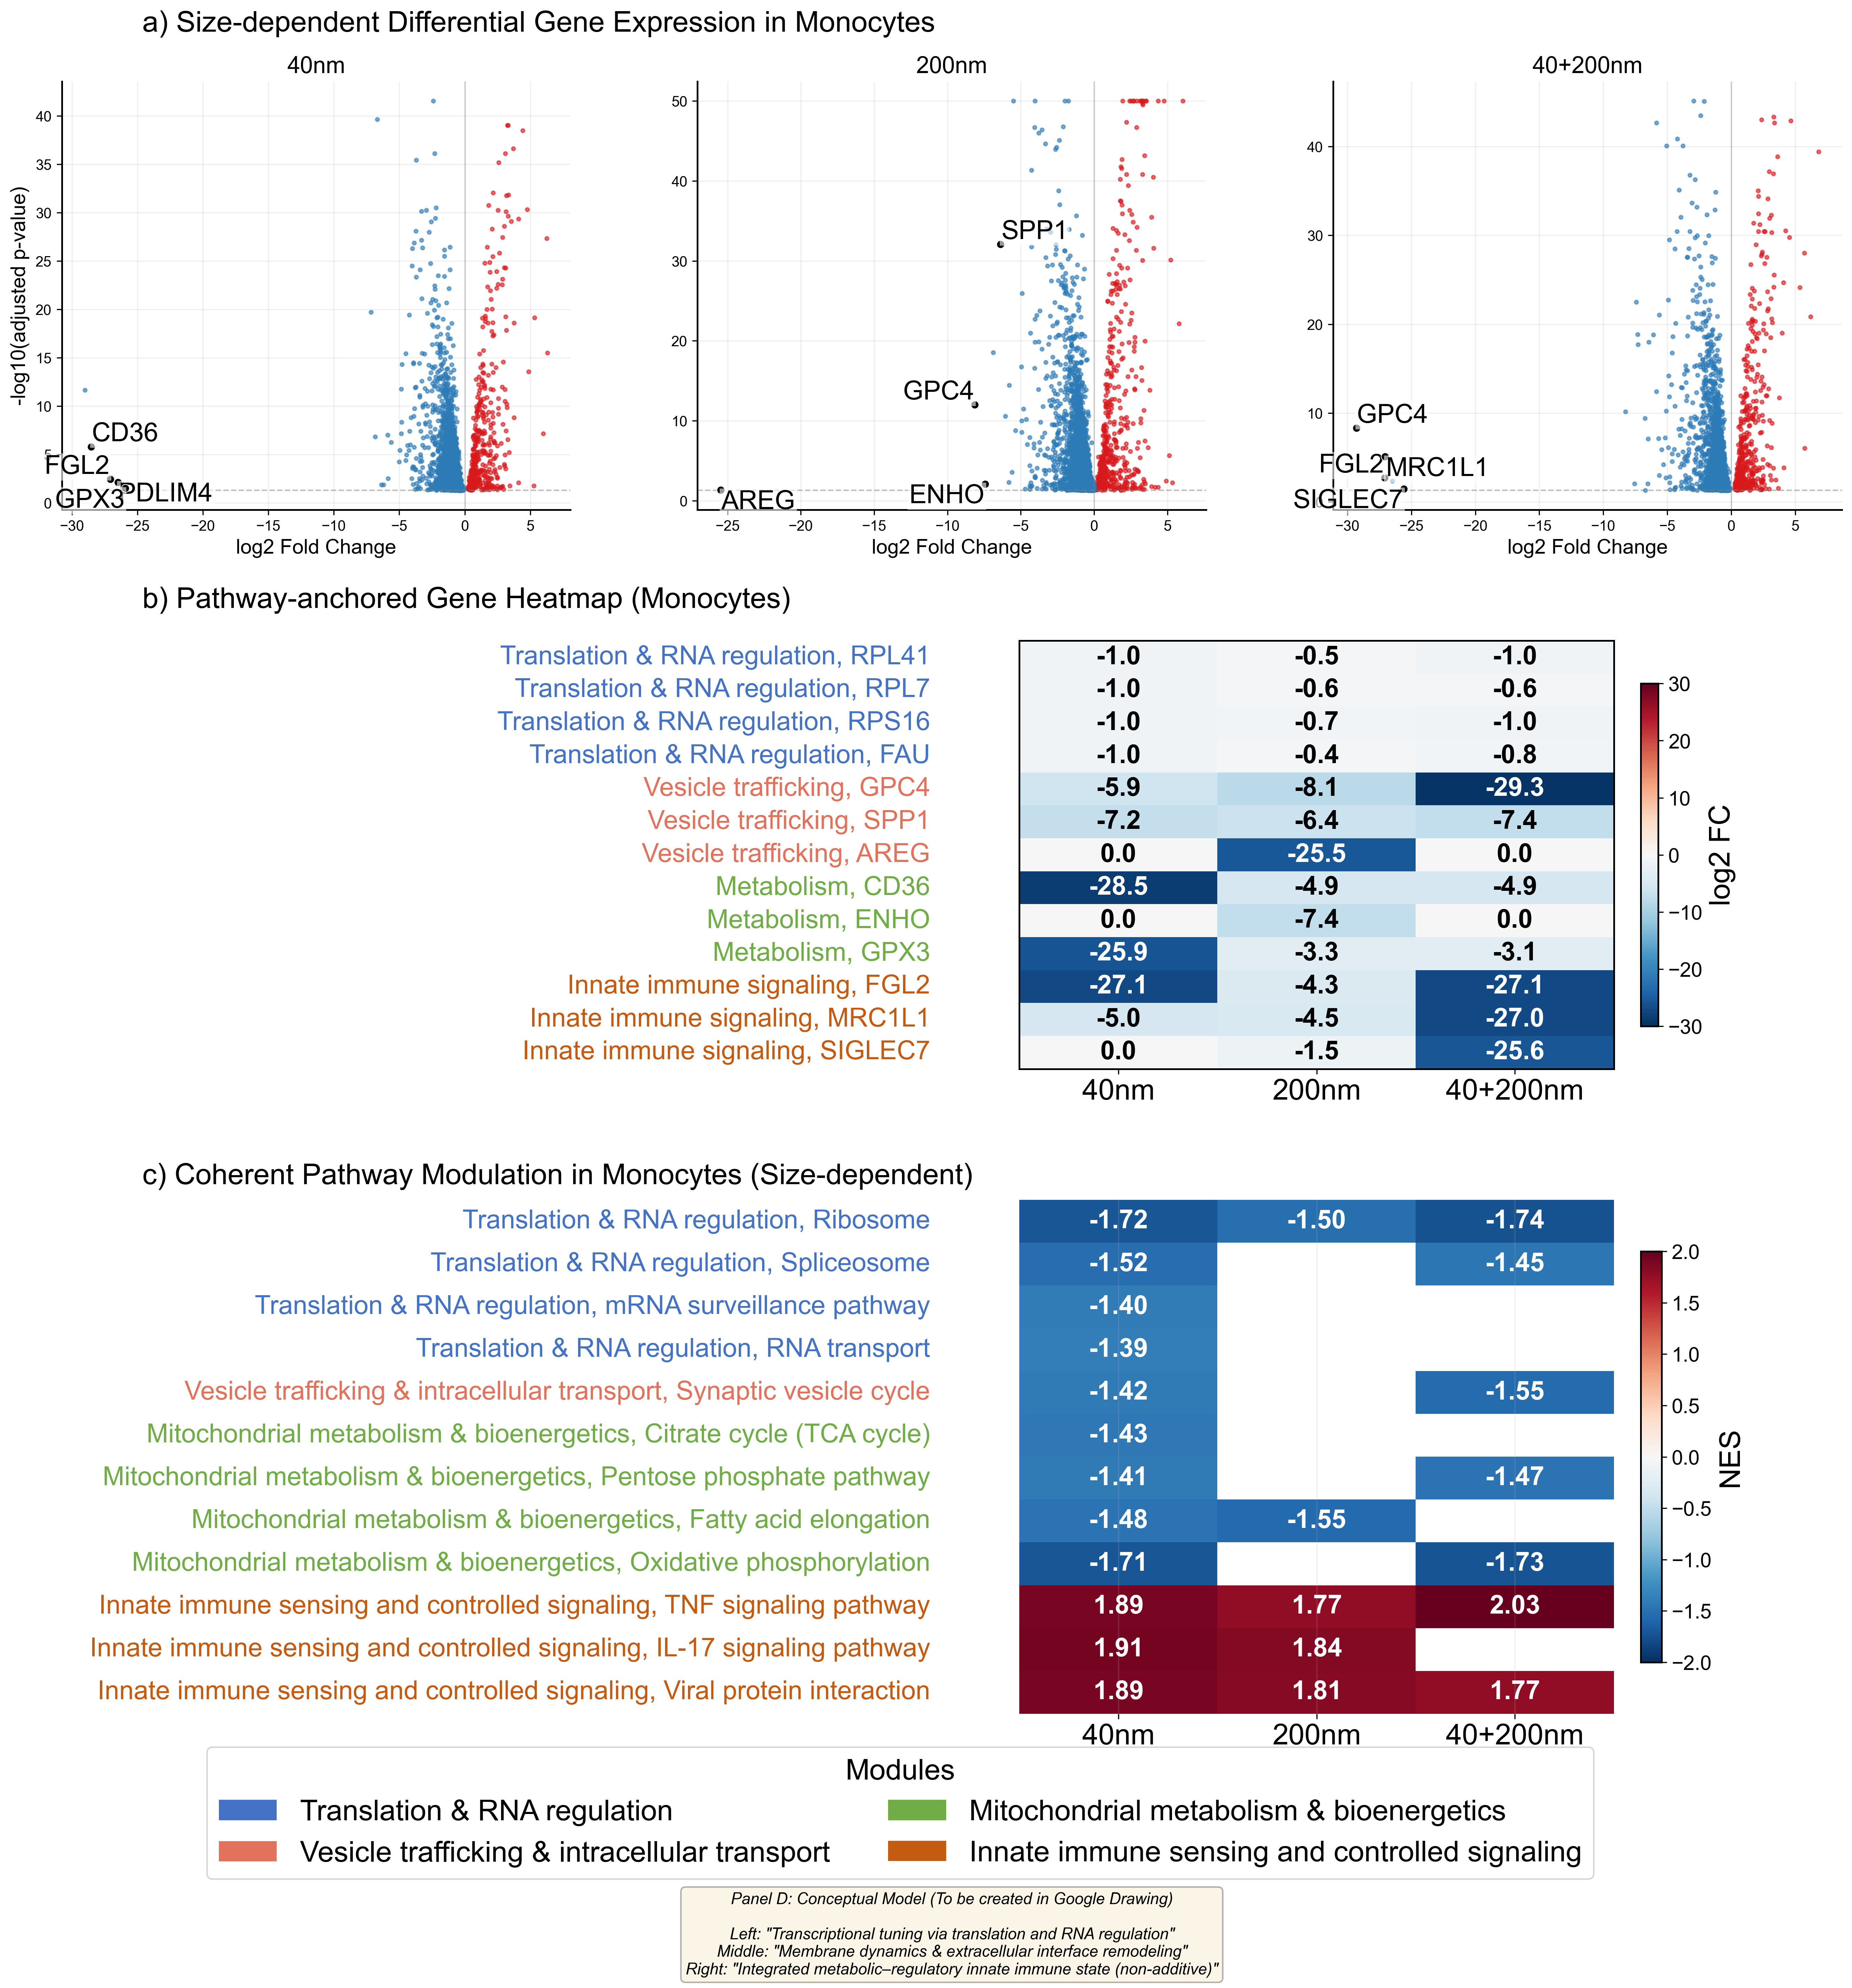

In [37]:
"""
FIGURE 4: Size-dependent transcriptional remodeling in monocytes following PSNP exposure
- Panel 4A: Three volcano plots for monocytes with labeled anchor genes
- Panel 4B: Pathway-anchored gene heatmap showing modules
- Panel 4C: Dot plot showing pathway coherence (modules × conditions)
- Panel 4D: Placeholder for conceptual model (Google Drawing)
"""
logger.info("Creating Figure 4...")

# Create figure
fig4 = plt.figure(figsize=(22, 24))
gs4 = fig4.add_gridspec(4, 1, hspace=0.35, height_ratios=[1, 1, 1.2, 0.3])

# ============================================================
# Panel 4A: Volcano Plots for Monocytes with Labeled Genes
# ============================================================
logger.info("  Panel 4A: Monocyte volcano plots...")

gs_4a = gs4[0].subgridspec(1, 3, wspace=0.25)

# Genes to label for each condition
genes_to_label = {
    '40nm': ['CD36', 'FGL2', 'PDLIM4', 'GPX3'],
    '200nm': ['SPP1', 'GPC4', 'AREG', 'ENHO'],
    '40+200nm': ['GPC4', 'FGL2', 'MRC1L1', 'SIGLEC7']
}

for i, (condition, genes) in enumerate(genes_to_label.items()):
    ax = fig4.add_subplot(gs_4a[0, i])
    
    # Get monocyte data
    sheet_name = get_sheet_name_fig2('CD14+ monocyte', condition)
    
    if sheet_name in de_results:
        df = de_results[sheet_name].copy()
        df['-log10_pval'] = -np.log10(df['pvals_adj'].replace(0, 1e-300))
        
        # Plot all points
        sig_mask = df['pvals_adj'] < 0.05
        up_mask = (df['logfoldchanges'] > 0) & sig_mask
        down_mask = (df['logfoldchanges'] < 0) & sig_mask
        
        ax.scatter(df.loc[~sig_mask, 'logfoldchanges'], df.loc[~sig_mask, '-log10_pval'],
                  c=REG_COLORS['Not Significant'], s=4, alpha=0.3, rasterized=True, zorder=1)
        ax.scatter(df.loc[up_mask, 'logfoldchanges'], df.loc[up_mask, '-log10_pval'],
                  c=REG_COLORS['Upregulated'], s=6, alpha=0.6, rasterized=True, zorder=2)
        ax.scatter(df.loc[down_mask, 'logfoldchanges'], df.loc[down_mask, '-log10_pval'],
                  c=REG_COLORS['Downregulated'], s=6, alpha=0.6, rasterized=True, zorder=2)
        
        # Label anchor genes
        offset = 0.04
        label_positions = [
            {'dx': offset, 'dy': 0.0, 'ha': 'left', 'va': 'center'},
            {'dx': -offset, 'dy': 0.0, 'ha': 'right', 'va': 'center'},
            {'dx': 0.0, 'dy': offset, 'ha': 'center', 'va': 'bottom'},
            {'dx': 0.0, 'dy': -offset, 'ha': 'center', 'va': 'top'},
            {'dx': offset, 'dy': offset, 'ha': 'left', 'va': 'bottom'},
            {'dx': -offset, 'dy': offset, 'ha': 'right', 'va': 'bottom'},
            {'dx': offset, 'dy': -offset, 'ha': 'left', 'va': 'top'},
            {'dx': -offset, 'dy': -offset, 'ha': 'right', 'va': 'top'},
        ]

        for j, gene in enumerate(genes):
            gene_data = df[df['names'] == gene]
            if len(gene_data) > 0:
                x = gene_data.iloc[0]['logfoldchanges']
                y = gene_data.iloc[0]['-log10_pval']
                ax.scatter([x], [y], c='black', s=30, marker='o', zorder=3, 
                           edgecolors='white', linewidths=0.5)
                pos = label_positions[(j + 4) % len(label_positions)]
                ax.text(x + pos['dx'], y + pos['dy'], f'{gene}', 
                        fontsize=18, ha=pos['ha'], va=pos['va'],
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

        ax.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axvline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.4)
    
    ax.set_xlabel('log2 Fold Change', fontsize=14)
    if i == 0:
        ax.set_ylabel('-log10(adjusted p-value)', fontsize=14)
    ax.set_title(f'{condition}', fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.2)

# Panel A title - aligned at x=0.08
fig4.text(0.16, 0.9, 'a) Size-dependent Differential Gene Expression in Monocytes',
         fontsize=20, ha='left')

# ============================================================
# Panel 4B: Pathway-anchored Gene Heatmap (Modules)
# ============================================================
HEATMAP_WIDTH_RATIO = 0.25
logger.info("  Panel 4B: Module-based gene heatmap...")

# Define modules and anchor genes
modules = {
    'Translation & RNA regulation': {
        'genes': ['RPL41', 'RPL7', 'RPS16', 'FAU'],
        'color': '#4472C4'
    },
    'Vesicle trafficking': {
        'genes': ['GPC4', 'SPP1', 'AREG'],
        'color': '#E2725B'
    },
    'Metabolism': {
        'genes': ['CD36', 'ENHO', 'GPX3'],
        'color': '#70AD47'
    },
    'Innate immune signaling': {
        'genes': ['FGL2', 'MRC1L1', 'SIGLEC7'],
        'color': '#C55A11'
    }
}

# Build gene list and colors
module_genes = []
module_colors = []
module_labels = []
for module_name, module_data in modules.items():
    for gene in module_data['genes']:
        module_genes.append(gene)
        module_colors.append(module_data['color'])
        module_labels.append(f"{module_name}, {gene}")

# Get log2FC for monocytes across conditions
monocyte_fc_data = []
for gene in module_genes:
    fc_row = []
    for condition in samples:
        sheet_name = get_sheet_name_fig2('CD14+ monocyte', condition)
        if sheet_name in de_results:
            df = de_results[sheet_name]
            gene_data = df[df['names'] == gene]
            if len(gene_data) > 0:
                fc_row.append(gene_data.iloc[0]['logfoldchanges'])
            else:
                fc_row.append(0)
        else:
            fc_row.append(0)
    monocyte_fc_data.append(fc_row)

fc_matrix = np.array(monocyte_fc_data)

# Use subgridspec to position heatmap with labels on left, heatmap in center, colorbar on right
# Adjust ratios to reduce white space - more space for labels, less padding
gs_4b = gs4[1].subgridspec(1, 3, width_ratios=[0.35, HEATMAP_WIDTH_RATIO, 0.05], wspace=0.02)
ax_4b = fig4.add_subplot(gs_4b[0, 1])

# Plot heatmap
im = ax_4b.imshow(fc_matrix, cmap=cmap, aspect='auto', vmin=-30, vmax=30)

# Annotate values
for i in range(fc_matrix.shape[0]):
    for j in range(fc_matrix.shape[1]):
        ax_4b.text(
            j, i,
            f"{fc_matrix[i, j]:.1f}",
            ha="center",
            va="center",
            fontsize=18,
            fontweight='bold',
            color="white" if abs(fc_matrix[i, j]) > 15 else "black")

# Y-axis: Module and gene labels - minimal spacing
ax_4b.set_yticks([])
ax_4b.tick_params(left=False)
for i, (label, color) in enumerate(zip(module_labels, module_colors)):
    ax_4b.text(-0.15, i, label, va='center', ha='right', fontsize=18,
              color=color, transform=ax_4b.get_yaxis_transform())

# X-axis: Conditions
ax_4b.set_xticks(range(len(samples)))
ax_4b.set_xticklabels(samples, fontsize=20)

# Colorbar - larger size
cbar = plt.colorbar(im, ax=ax_4b, fraction=0.08, pad=0.04, shrink=0.8)
cbar.set_label('log2 FC', fontsize=20)
cbar.ax.tick_params(labelsize=14)

# Panel B title - aligned with panel A at x=0.16
fig4.text(0.16, 0.67, 'b) Pathway-anchored Gene Heatmap (Monocytes)',
         fontsize=20, ha='left')

# ============================================================
# Panel 4C: Dot Plot - Pathway Coherence by Module
# ============================================================
logger.info("  Panel 4C: Pathway coherence dot plot...")

# Define pathways by module
module_pathways = {
    'Translation & RNA regulation': [
        'Ribosome', 'Spliceosome', 'mRNA surveillance pathway', 'RNA transport'
    ],
    'Vesicle trafficking & intracellular transport': [
        'Synaptic vesicle cycle'
    ],
    'Mitochondrial metabolism & bioenergetics': [
        'Citrate cycle (TCA cycle)', 'Pentose phosphate pathway',
        'Fatty acid elongation', 'Oxidative phosphorylation'
    ],
    'Innate immune sensing and controlled signaling': [
        'TNF signaling pathway', 'IL-17 signaling pathway',
        'Viral protein interaction'
    ]
}

# Colors for modules
module_colors_dict = {
    'Translation & RNA regulation': '#4472C4',
    'Vesicle trafficking & intracellular transport': '#E2725B',
    'Mitochondrial metabolism & bioenergetics': '#70AD47',
    'Innate immune sensing and controlled signaling': '#C55A11'
}

# Build pathway list with module info
pathway_entries = []
pathway_colors_list = []
for module_name, pathways in module_pathways.items():
    for pathway in pathways:
        pathway_entries.append(f"{module_name}, {pathway}")
        pathway_colors_list.append(module_colors_dict[module_name])

# Get NES values for monocytes
nes_values_4c = []
for module_name, pathways in module_pathways.items():
    for pathway in pathways:
        nes_row = []
        for condition in samples:
            sheet_name = get_gse_sheet_name('CD14+ monocyte', condition)
            if sheet_name in gse_results:
                df = gse_results[sheet_name]
                term_col = 'KEGG Term' if 'KEGG Term' in df.columns else 'Term'
                matches = df[df[term_col] == pathway]
                if len(matches) == 0:
                    matches = df[df[term_col].str.contains(pathway, case=False, na=False, regex=False)]
                if len(matches) > 0:
                    nes_row.append(matches.iloc[0]['NES'])
                else:
                    nes_row.append(np.nan)
            else:
                nes_row.append(np.nan)
        nes_values_4c.append(nes_row)

nes_matrix_4c = np.array(nes_values_4c)

# Use same subgridspec layout as panel B for alignment
gs_4c = gs4[2].subgridspec(1, 3, width_ratios=[0.35, HEATMAP_WIDTH_RATIO, 0.05], wspace=0.02)
ax_4c = fig4.add_subplot(gs_4c[0, 1])

# Plot heatmap
im2 = ax_4c.imshow(nes_matrix_4c, cmap=cmap, aspect='auto', vmin=-2, vmax=2)

# Annotate values with white font
for i in range(nes_matrix_4c.shape[0]):
    for j in range(nes_matrix_4c.shape[1]):
        val = nes_matrix_4c[i, j]
        if not np.isnan(val):
            ax_4c.text(
                j, i,
                f"{val:.2f}",
                ha="center",
                va="center",
                fontsize=18,
                color="white",
                fontweight='bold')

# Y-axis: Module and pathway labels - minimal spacing
ax_4c.set_yticks([])
ax_4c.tick_params(left=False)
for i, (label, color) in enumerate(zip(pathway_entries, pathway_colors_list)):
    ax_4c.text(-0.15, i, label, va='center', ha='right', fontsize=18,
              color=color, transform=ax_4c.get_yaxis_transform())

# X-axis: Conditions
ax_4c.set_xticks(range(len(samples)))
ax_4c.set_xticklabels(samples, fontsize=20)

# Colorbar - larger size
cbar2 = plt.colorbar(im2, ax=ax_4c, fraction=0.08, pad=0.04, shrink=0.8)
cbar2.set_label('NES', fontsize=20)
cbar2.ax.tick_params(labelsize=14)

# Panel C title - aligned with panels A and B at x=0.08
fig4.text(0.16, 0.44, 'c) Coherent Pathway Modulation in Monocytes (Size-dependent)',
         fontsize=20, ha='left')

ax_4c.grid(True, alpha=0.2)
for spine in ax_4c.spines.values():
    spine.set_visible(False)

# Legend
legend_elements = [Patch(facecolor=color, label=module) 
                   for module, color in module_colors_dict.items()]
ax_4c.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(-0.2, -0.35),
            fontsize=20, frameon=True, title='Modules', ncol=2, title_fontsize=20)

# ============================================================
# Panel 4D: Placeholder for Google Drawing
# ============================================================
ax_4d = fig4.add_subplot(gs4[3])
ax_4d.text(0.5, 0.3, 
          'Panel D: Conceptual Model (To be created in Google Drawing)\n\n' +
          'Left: "Transcriptional tuning via translation and RNA regulation"\n' +
          'Middle: "Membrane dynamics & extracellular interface remodeling"\n' +
          'Right: "Integrated metabolic–regulatory innate immune state (non-additive)"',
          ha='center', va='center', fontsize=11, style='italic',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax_4d.axis('off')

plt.savefig(FIG_DIR / 'Figure_4_monocyte_remodeling.pdf', bbox_inches='tight')
logger.info("✓ Figure 4 complete\n")

# ============================================================
# FIGURE 5: Adaptive Immune Cells - Restrained and Lineage-specific Responses
# ============================================================
 
 Figure 5 demonstrates that B cells and CD4+ T cells exhibit transcriptional 
 responses that are more restrained and lineage-specific compared to innate cells.
 
 Panel 5A: DEG burden in adaptive immune cells (B cells, CD4+ T cells) across conditions
 Panel 5B: Lineage-specific gene modulation (MS4A1, CD79A, CD74, CCR7, LTB, RPL7, RPS6)
 Panel 5C: Pathway enrichment showing limited coherence in adaptive cells

13:57:23 - INFO - Creating Figure 5...
13:57:23 - INFO -   Panel 5a: Adaptive immune cell volcano plots...
13:57:24 - INFO -   Panel 5b: Adaptive immunity gene heatmap...
13:57:27 - INFO - ✓ Figure 5 complete



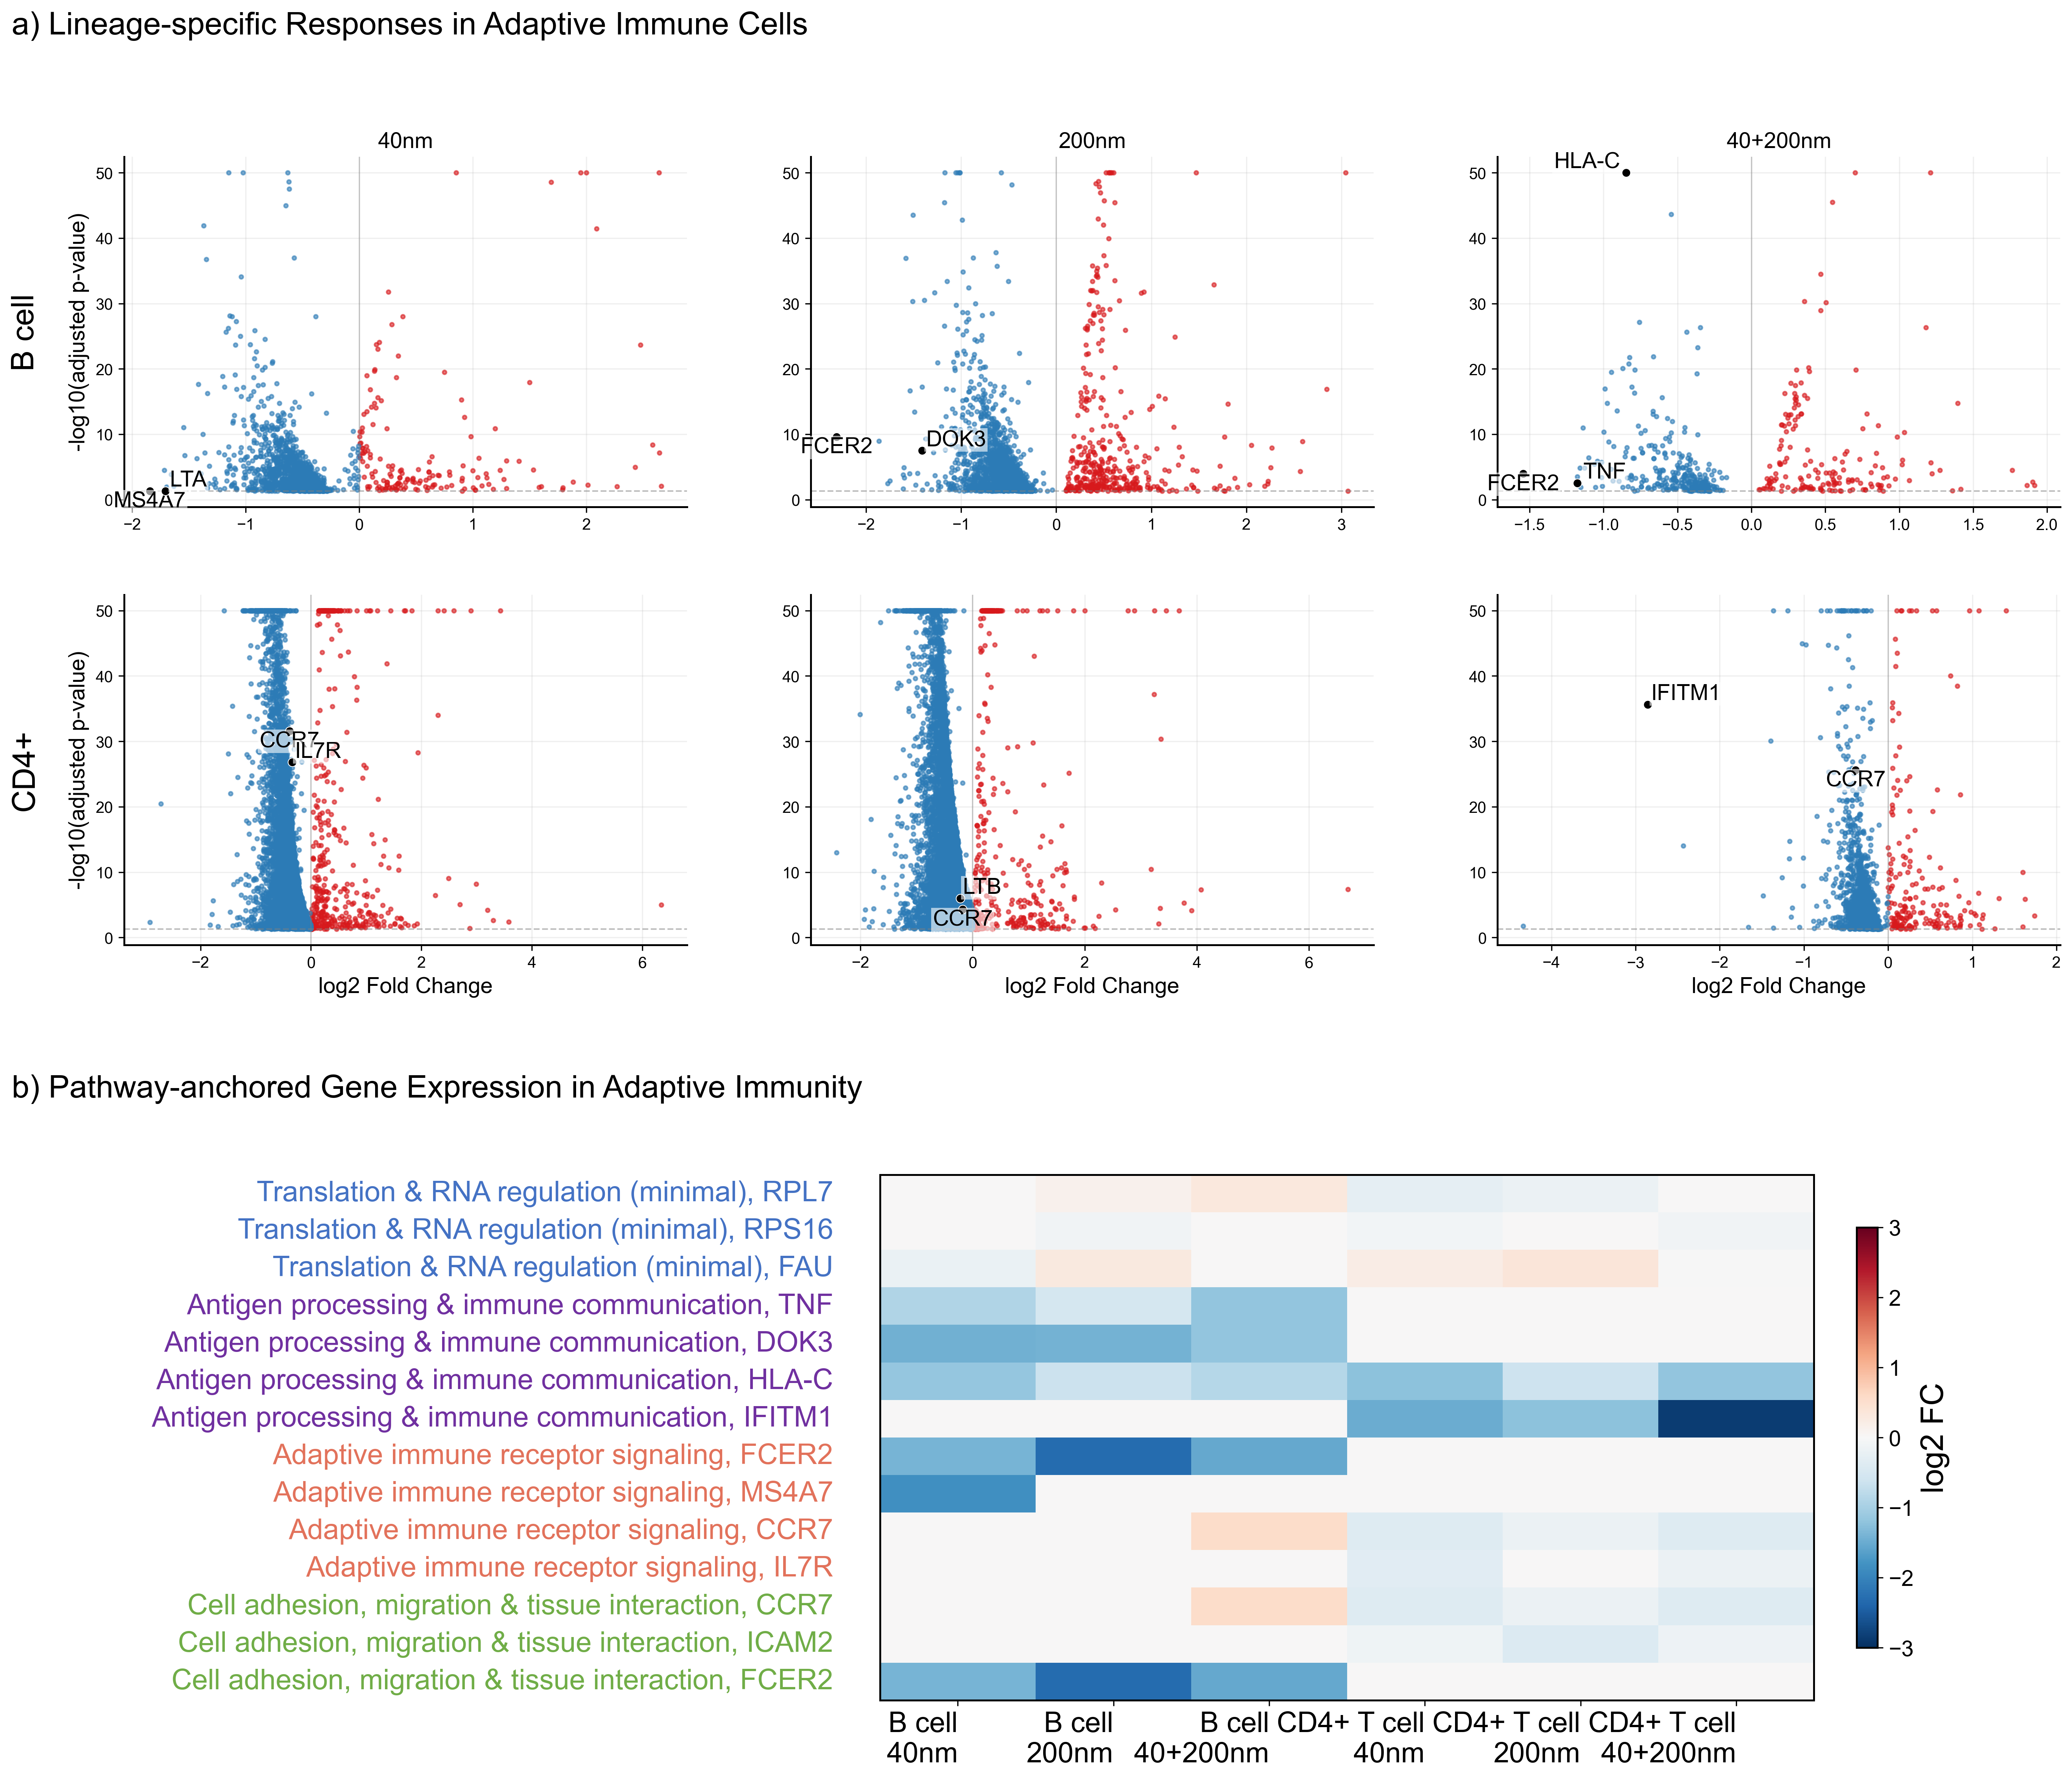

In [51]:
"""
FIGURE 5: Adaptive immune cells display restrained and lineage-specific responses
- Panel 5A: Volcano plots for B cells and CD4+ T cells (3 conditions each)
- Panel 5B: Pathway-anchored heatmap showing adaptive immunity modules
"""
logger.info("Creating Figure 5...")

# Create figure
fig5 = plt.figure(figsize=(22, 18))
gs5 = fig5.add_gridspec(2, 1, hspace=0.35, height_ratios=[1.5, 1])

# ============================================================
# Panel 5A: Volcano Plots for Adaptive Immune Cells
# ============================================================
logger.info("  Panel 5a: Adaptive immune cell volcano plots...")

gs_5a = gs5[0].subgridspec(2, 3, hspace=0.25, wspace=0.22)

# Genes to label for B cells and CD4+ T cells
adaptive_genes_to_label = {
    'B cell': {
        '40nm': ['MS4A7', 'LTA'],
        '200nm': ['FCER2', 'DOK3'],
        '40+200nm': ['FCER2', 'TNF', 'HLA-C']
    },
    'CD4+ T cell': {
        '40nm': ['CCR7', 'IL7R'],
        '200nm': ['CCR7', 'LTB'],
        '40+200nm': ['CCR7', 'IFITM1']
    }
}

cell_types_adaptive = ['B cell', 'CD4+ T cell']

for i, cell_type in enumerate(cell_types_adaptive):
    for j, condition in enumerate(samples):
        ax = fig5.add_subplot(gs_5a[i, j])
        
        sheet_name = get_sheet_name_fig2(cell_type, condition)
        genes = adaptive_genes_to_label[cell_type][condition]
        
        if sheet_name in de_results:
            df = de_results[sheet_name].copy()
            df['-log10_pval'] = -np.log10(df['pvals_adj'].replace(0, 1e-300))

            # Plot all points
            sig_mask = df['pvals_adj'] < 0.05
            up_mask = (df['logfoldchanges'] > 0) & sig_mask
            down_mask = (df['logfoldchanges'] < 0) & sig_mask

            ax.scatter(df.loc[~sig_mask, 'logfoldchanges'], df.loc[~sig_mask, '-log10_pval'],
                      c=REG_COLORS['Not Significant'], s=4, alpha=0.3, rasterized=True, zorder=1)
            ax.scatter(df.loc[up_mask, 'logfoldchanges'], df.loc[up_mask, '-log10_pval'],
                      c=REG_COLORS['Upregulated'], s=6, alpha=0.6, rasterized=True, zorder=2)
            ax.scatter(df.loc[down_mask, 'logfoldchanges'], df.loc[down_mask, '-log10_pval'],
                      c=REG_COLORS['Downregulated'], s=6, alpha=0.6, rasterized=True, zorder=2)

            # Label anchor genes
            offset = 0.04
            label_positions = [
                {'dx': offset, 'dy': 0.0, 'ha': 'left', 'va': 'center'},
                {'dx': -offset, 'dy': 0.0, 'ha': 'right', 'va': 'center'},
                {'dx': 0.0, 'dy': offset, 'ha': 'center', 'va': 'bottom'},
                {'dx': 0.0, 'dy': -offset, 'ha': 'center', 'va': 'top'},
                {'dx': offset, 'dy': offset, 'ha': 'left', 'va': 'bottom'},
                {'dx': -offset, 'dy': offset, 'ha': 'right', 'va': 'bottom'},
                {'dx': offset, 'dy': -offset, 'ha': 'left', 'va': 'top'},
                {'dx': -offset, 'dy': -offset, 'ha': 'right', 'va': 'top'},
            ]

            for k, gene in enumerate(genes):
                gene_data = df[df['names'] == gene]
                if len(gene_data) > 0:
                    x = gene_data.iloc[0]['logfoldchanges']
                    y = gene_data.iloc[0]['-log10_pval']
                    ax.scatter([x], [y], c='black', s=30, marker='o', zorder=3, 
                               edgecolors='white', linewidths=0.5)
                    pos = label_positions[(k + 3) % len(label_positions)]
                    ax.text(x + pos['dx'], y + pos['dy'], f'{gene}', 
                            fontsize=14, ha=pos['ha'], va=pos['va'],
                            bbox=dict(facecolor='w', alpha=0.6, edgecolor='none', pad=1))

            ax.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1, alpha=0.5)
            ax.axvline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.4)
        
        if i == 1:
            ax.set_xlabel('log2 Fold Change', fontsize=14)
        if j == 0:
            ax.set_ylabel('-log10(adjusted p-value)', fontsize=14)
        if i == 0:
            ax.set_title(f'{condition}', fontsize=14)
        if j == 0:
            ax.text(-0.15, 0.5, cell_type.replace(' T cell',''), transform=ax.transAxes,
                   rotation=90, va='center', ha='right', fontsize=20)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, alpha=0.2)

# Panel a title - aligned at x=0.08
fig5.text(0.08, 0.94, 'a) Lineage-specific Responses in Adaptive Immune Cells',
         fontsize=20, ha='left')

# ============================================================
# Panel 5B: Pathway-anchored Heatmap (Adaptive Immunity)
# ============================================================
logger.info("  Panel 5b: Adaptive immunity gene heatmap...")

# Define modules for adaptive immunity
adaptive_modules = {
    'Translation & RNA regulation (minimal)': {
        'genes': ['RPL7', 'RPS16', 'FAU'],
        'color': '#4472C4'
    },
    'Antigen processing & immune communication': {
        'genes': ['TNF', 'DOK3', 'HLA-C', 'IFITM1'],
        'color': '#7030A0'
    },
    'Adaptive immune receptor signaling': {
        'genes': ['FCER2', 'MS4A7', 'CCR7', 'IL7R'],
        'color': '#E2725B'
    },
    'Cell adhesion, migration & tissue interaction': {
        'genes': ['CCR7', 'ICAM2', 'FCER2'],
        'color': '#70AD47'
    }
}

# Build gene list
adaptive_gene_list = []
adaptive_gene_colors = []
adaptive_gene_labels = []
for module_name, module_data in adaptive_modules.items():
    for gene in module_data['genes']:
        adaptive_gene_list.append(gene)
        adaptive_gene_colors.append(module_data['color'])
        adaptive_gene_labels.append(f"{module_name}, {gene}")

# Get log2FC for B cells and CD4+ T cells
adaptive_fc_data = []
adaptive_conditions = []

for cell_type in cell_types_adaptive:
    for condition in samples:
        adaptive_conditions.append(f"{cell_type}\n{condition}")

for gene in adaptive_gene_list:
    fc_row = []
    for cell_type in cell_types_adaptive:
        for condition in samples:
            sheet_name = get_sheet_name_fig2(cell_type, condition)
            if sheet_name in de_results:
                df = de_results[sheet_name]
                gene_data = df[df['names'] == gene]
                if len(gene_data) > 0:
                    fc_row.append(gene_data.iloc[0]['logfoldchanges'])
                else:
                    fc_row.append(0)
            else:
                fc_row.append(0)
    adaptive_fc_data.append(fc_row)

adaptive_fc_matrix = np.array(adaptive_fc_data)

# Use subgridspec to control heatmap width - align with panel a
HEATMAP_WIDTH_RATIO_FIG5 = 0.5
gs_5b = gs5[1].subgridspec(1, 3, width_ratios=[0.35, HEATMAP_WIDTH_RATIO_FIG5, 0.05], wspace=0.02)
ax_5b = fig5.add_subplot(gs_5b[0, 1])

# Plot heatmap
im = ax_5b.imshow(adaptive_fc_matrix, cmap=cmap, aspect='auto', vmin=-3, vmax=3)

# Y-axis: Remove yticks, add labels with minimal spacing
ax_5b.set_yticks([])
ax_5b.tick_params(left=False)
for i, (label, color) in enumerate(zip(adaptive_gene_labels, adaptive_gene_colors)):
    ax_5b.text(-0.05, i, label, va='center', ha='right', fontsize=18,
              color=color, transform=ax_5b.get_yaxis_transform())

# X-axis labels
ax_5b.set_xticks(range(len(adaptive_conditions)))
ax_5b.set_xticklabels(adaptive_conditions, rotation=0, ha='right', fontsize=18)

# Colorbar - larger size
cbar = plt.colorbar(im, ax=ax_5b, fraction=0.08, pad=0.04, shrink=0.8)
cbar.set_label('log2 FC', fontsize=20)
cbar.ax.tick_params(labelsize=14)

# Panel b title - aligned with panel a at x=0.08
fig5.text(0.08, 0.42, 'b) Pathway-anchored Gene Expression in Adaptive Immunity',
         fontsize=20, ha='left')

# Module legend
# legend_elements = [Patch(facecolor=module_data['color'], label=module_name)
#                    for module_name, module_data in adaptive_modules.items()]
# ax_5b.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.05, -0.36),
#             fontsize=18, frameon=True, ncol=2)

plt.savefig(FIG_DIR / 'Figure_5_adaptive_immunity.pdf', bbox_inches='tight')
logger.info("✓ Figure 5 complete\n")

# ============================================================
# FIGURE 6: Integrative Principles of Immune Transcriptional Organization
# ============================================================

13:59:12 - INFO - Creating Figure 6...
13:59:12 - INFO -   Panel 6A: Cross-cell-type dot plot...
13:59:14 - INFO -   Panel 6B: Schematic comparison...
13:59:14 - INFO -   Panel 6C: Conceptual model placeholder...
13:59:15 - INFO - ✓ Figure 6 complete



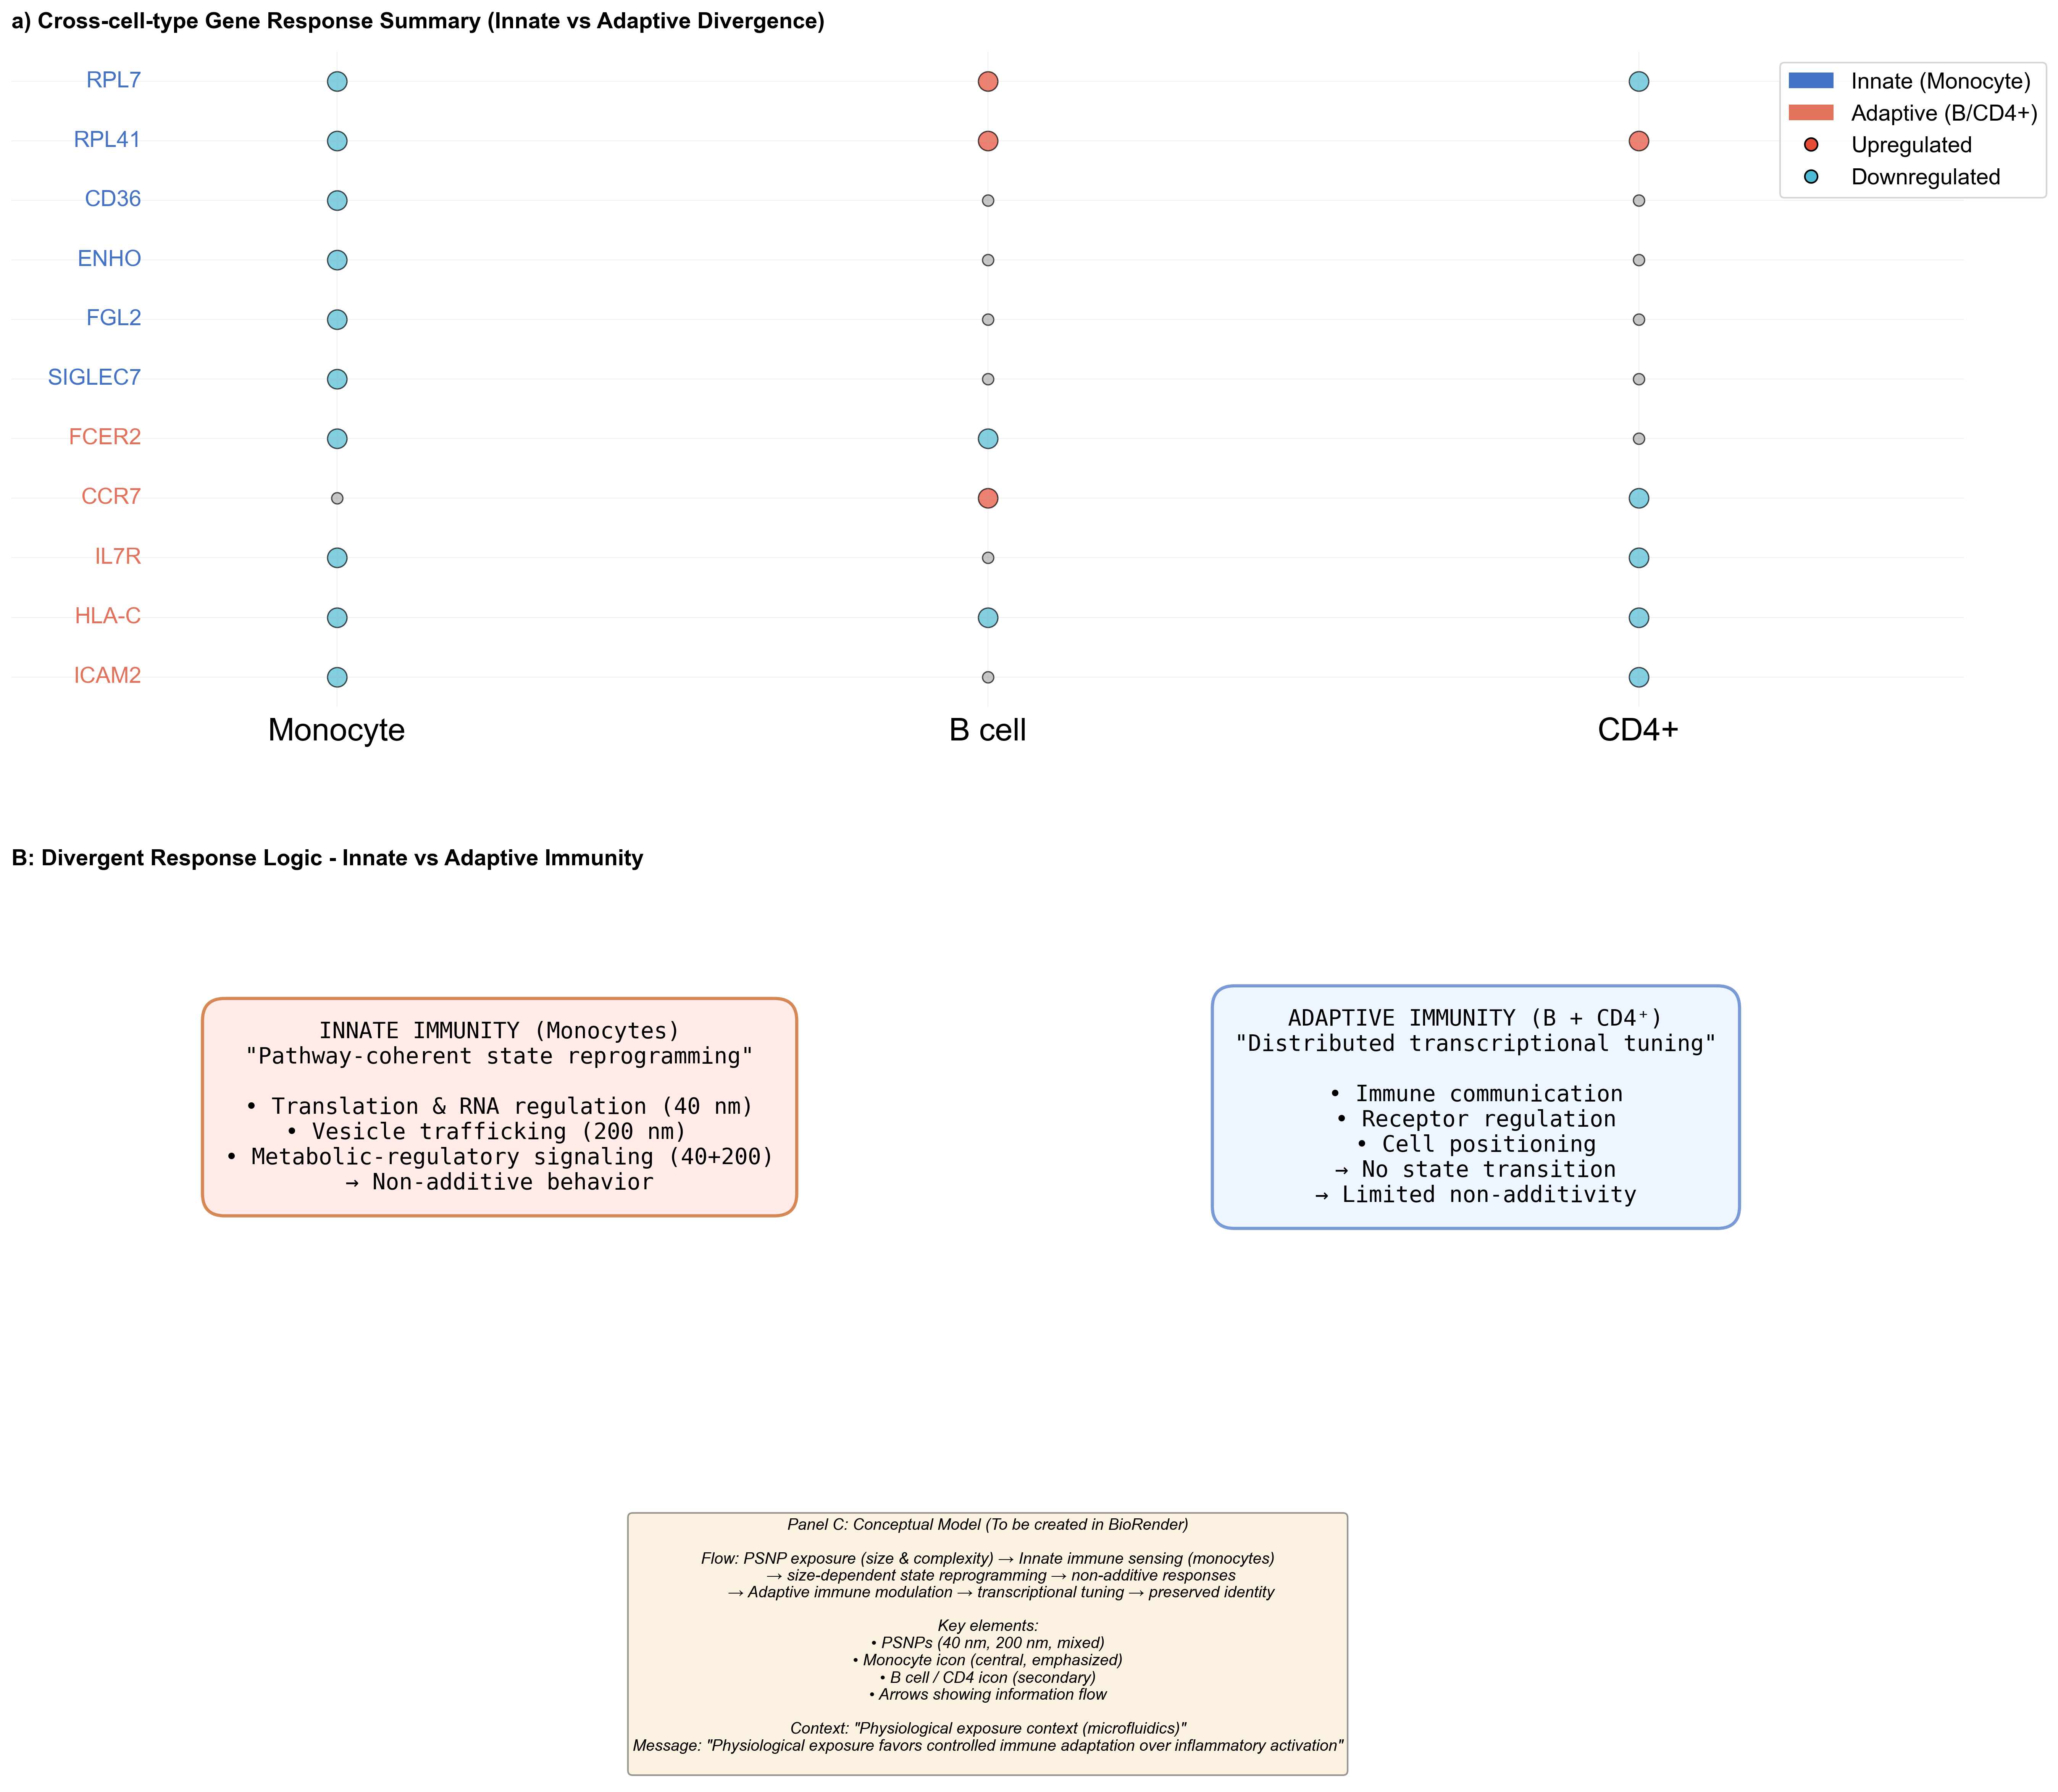

In [54]:
"""
FIGURE 6: Innate vs adaptive immune divergence under PSNP exposure
- Panel 6A: Cross-cell-type gene response summary (dot plot)
- Panel 6B: State coherence vs transcriptional modulation (schematic)
- Panel 6C: Conceptual model (placeholder for BioRender)
"""
logger.info("Creating Figure 6...")

# Create figure
fig6 = plt.figure(figsize=(22, 20))
gs6 = fig6.add_gridspec(3, 1, hspace=0.40, height_ratios=[1.2, 0.8, 0.5])

# ============================================================
# Panel 6A: Cross-cell-type Gene Response Summary
# ============================================================
logger.info("  Panel 6A: Cross-cell-type dot plot...")

ax_6a = fig6.add_subplot(gs6[0])

# Define innate and adaptive anchor genes
innate_genes = {
    'genes': ['RPL7', 'RPL41', 'CD36', 'ENHO', 'FGL2', 'SIGLEC7'],
    'color': '#4472C4',
    'label': 'Innate (Monocyte)'
}

adaptive_genes = {
    'genes': ['FCER2', 'CCR7', 'IL7R', 'HLA-C', 'ICAM2'],
    'color': '#E2725B',
    'label': 'Adaptive (B/CD4+)'
}

# Cell types to compare
cell_types_6a = ['CD14+ monocyte', 'B cell', 'CD4+ T cell']

# Collect gene list
gene_list_6a = innate_genes['genes'] + adaptive_genes['genes']
gene_colors_6a = [innate_genes['color']] * len(innate_genes['genes']) + \
                  [adaptive_genes['color']] * len(adaptive_genes['genes'])

# Load expression data from h5ad for % expressing calculation
try:
    adata = sc.read_h5ad('./merged_umap.h5ad')
    has_expression_data = True
except:
    has_expression_data = False
    logger.warning("  Could not load expression data for % expressing")

# Get log2FC and expression percentage for each gene × cell type
dot_plot_data = []

for gene in gene_list_6a:
    for cell_type in cell_types_6a:
        # Get average log2FC across conditions
        fc_values = []
        for condition in samples:
            sheet_name = get_sheet_name_fig2(cell_type, condition)
            if sheet_name in de_results:
                df = de_results[sheet_name]
                gene_data = df[df['names'] == gene]
                if len(gene_data) > 0:
                    fc_values.append(gene_data.iloc[0]['logfoldchanges'])
        
        avg_fc = np.mean(fc_values) if fc_values else 0
        
        # Calculate % expressing
        if has_expression_data and gene in adata.var_names:
            cell_mask = adata.obs['cell_type'] == cell_type
            gene_idx = adata.var_names.tolist().index(gene)
            expressing = (adata.X[cell_mask, gene_idx] > 0).sum()
            total = cell_mask.sum()
            pct_expressing = (expressing / total * 100) if total > 0 else 0
        else:
            # Estimate based on significance
            pct_expressing = 30 if avg_fc != 0 else 10
        
        dot_plot_data.append({
            'gene': gene,
            'cell_type': cell_type,
            'avg_fc': avg_fc,
            'pct_expressing': pct_expressing
        })

# Create dot plot
y_pos = {}
for i, gene in enumerate(gene_list_6a):
    y_pos[gene] = i

x_pos = {ct: i for i, ct in enumerate(cell_types_6a)}

for entry in dot_plot_data:
    gene = entry['gene']
    ct = entry['cell_type']
    fc = entry['avg_fc']
    pct = entry['pct_expressing']
    
    x = x_pos[ct]
    y = y_pos[gene]
    
    # Size based on % expressing
    size = pct * 5
    
    # Color based on avg_fc
    if fc > 0:
        color = '#E64B35'  # Red for up
    elif fc < 0:
        color = '#4DBBD5'  # Blue for down
    else:
        color = '#B0B0B0'  # Gray for no change
    
    ax_6a.scatter(x, y, s=size, c=[color], alpha=0.7, edgecolors='black', linewidths=0.8)

# Gene labels with colors
ax_6a.set_yticks(range(len(gene_list_6a)))
for i, (gene, color) in enumerate(zip(gene_list_6a, gene_colors_6a)):
    ax_6a.text(-0.3, i, gene, va='center', ha='right', fontsize=14,
              color=color)
ax_6a.set_yticklabels([])

# Cell type labels
ax_6a.set_xticks(range(len(cell_types_6a)))

ax_6a.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in cell_types_6a],
                      fontsize=20)
ax_6a.tick_params(axis='x', bottom=False)
ax_6a.tick_params(axis='y', left=False)

ax_6a.set_title('a) Cross-cell-type Gene Response Summary (Innate vs Adaptive Divergence)',
               fontsize=14, fontweight='bold', loc='left', pad=15)
ax_6a.set_xlim(-0.5, len(cell_types_6a) - 0.5)
ax_6a.set_ylim(-0.5, len(gene_list_6a) - 0.5)
ax_6a.grid(True, alpha=0.2, linewidth=0.5)
ax_6a.spines['top'].set_visible(False)
ax_6a.spines['right'].set_visible(False)
ax_6a.spines['bottom'].set_visible(False)
ax_6a.spines['left'].set_visible(False)
ax_6a.invert_yaxis()

# Legend
legend_elements = [
    Patch(facecolor=innate_genes['color'], label=innate_genes['label']),
    Patch(facecolor=adaptive_genes['color'], label=adaptive_genes['label']),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E64B35',
               markersize=8, label='Upregulated', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4DBBD5',
               markersize=8, label='Downregulated', markeredgecolor='black')
]
ax_6a.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.9, 1),
            fontsize=14, frameon=True)

# ============================================================
# Panel 6B: State Coherence vs Transcriptional Modulation
# ============================================================
logger.info("  Panel 6B: Schematic comparison...")

ax_6b = fig6.add_subplot(gs6[1])
ax_6b.axis('off')

# Create side-by-side comparison
left_text = """INNATE IMMUNITY (Monocytes)
"Pathway-coherent state reprogramming"

• Translation & RNA regulation (40 nm)
• Vesicle trafficking (200 nm)  
• Metabolic-regulatory signaling (40+200)
→ Non-additive behavior"""

right_text = """ADAPTIVE IMMUNITY (B + CD4⁺)
"Distributed transcriptional tuning"

• Immune communication
• Receptor regulation
• Cell positioning
→ No state transition
→ Limited non-additivity"""

ax_6b.text(0.25, 0.5, left_text, ha='center', va='center', fontsize=14,
          bbox=dict(boxstyle='round,pad=1', facecolor='#FFE4E1', alpha=0.7, edgecolor='#C55A11', linewidth=2),
          family='monospace')

ax_6b.text(0.75, 0.5, right_text, ha='center', va='center', fontsize=14,
          bbox=dict(boxstyle='round,pad=1', facecolor='#E6F2FF', alpha=0.7, edgecolor='#4472C4', linewidth=2),
          family='monospace')

ax_6b.set_xlim(0, 1)
ax_6b.set_ylim(0, 1)
ax_6b.set_title('B: Divergent Response Logic - Innate vs Adaptive Immunity',
               fontsize=14, fontweight='bold', loc='left', pad=15)

# ============================================================
# Panel 6C: Conceptual Model Placeholder
# ============================================================
logger.info("  Panel 6C: Conceptual model placeholder...")

ax_6c = fig6.add_subplot(gs6[2])
ax_6c.axis('off')

conceptual_text = """Panel C: Conceptual Model (To be created in BioRender)

Flow: PSNP exposure (size & complexity) → Innate immune sensing (monocytes)
      → size-dependent state reprogramming → non-additive responses
      → Adaptive immune modulation → transcriptional tuning → preserved identity

Key elements:
• PSNPs (40 nm, 200 nm, mixed)
• Monocyte icon (central, emphasized)
• B cell / CD4 icon (secondary)
• Arrows showing information flow

Context: "Physiological exposure context (microfluidics)"
Message: "Physiological exposure favors controlled immune adaptation over inflammatory activation"
"""

ax_6c.text(0.5, 0.5, conceptual_text, ha='center', va='center', fontsize=10,
          style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.4))
ax_6c.set_xlim(0, 1)
ax_6c.set_ylim(0, 1)


plt.savefig(FIG_DIR / 'Figure_6_innate_vs_adaptive.pdf', bbox_inches='tight')
logger.info("✓ Figure 6 complete\n")

# ============================================================
# SUPPLEMENTARY FIGURES
# ============================================================

13:58:05 - INFO - Creating Supplementary Figure S1 (QC and robustness)...
13:58:11 - INFO -   Loaded data for QC analysis
13:58:13 - INFO - a) QC metrics by condition
13:58:13 - INFO - Panel S1B: QC metrics by cell type...
13:58:13 - INFO -   Panel S1C: Pseudobulk PCA
13:58:18 - INFO -   Panel S1D: Marker gene validation...
13:58:24 - INFO - ✓ Supplementary Figure S1 complete



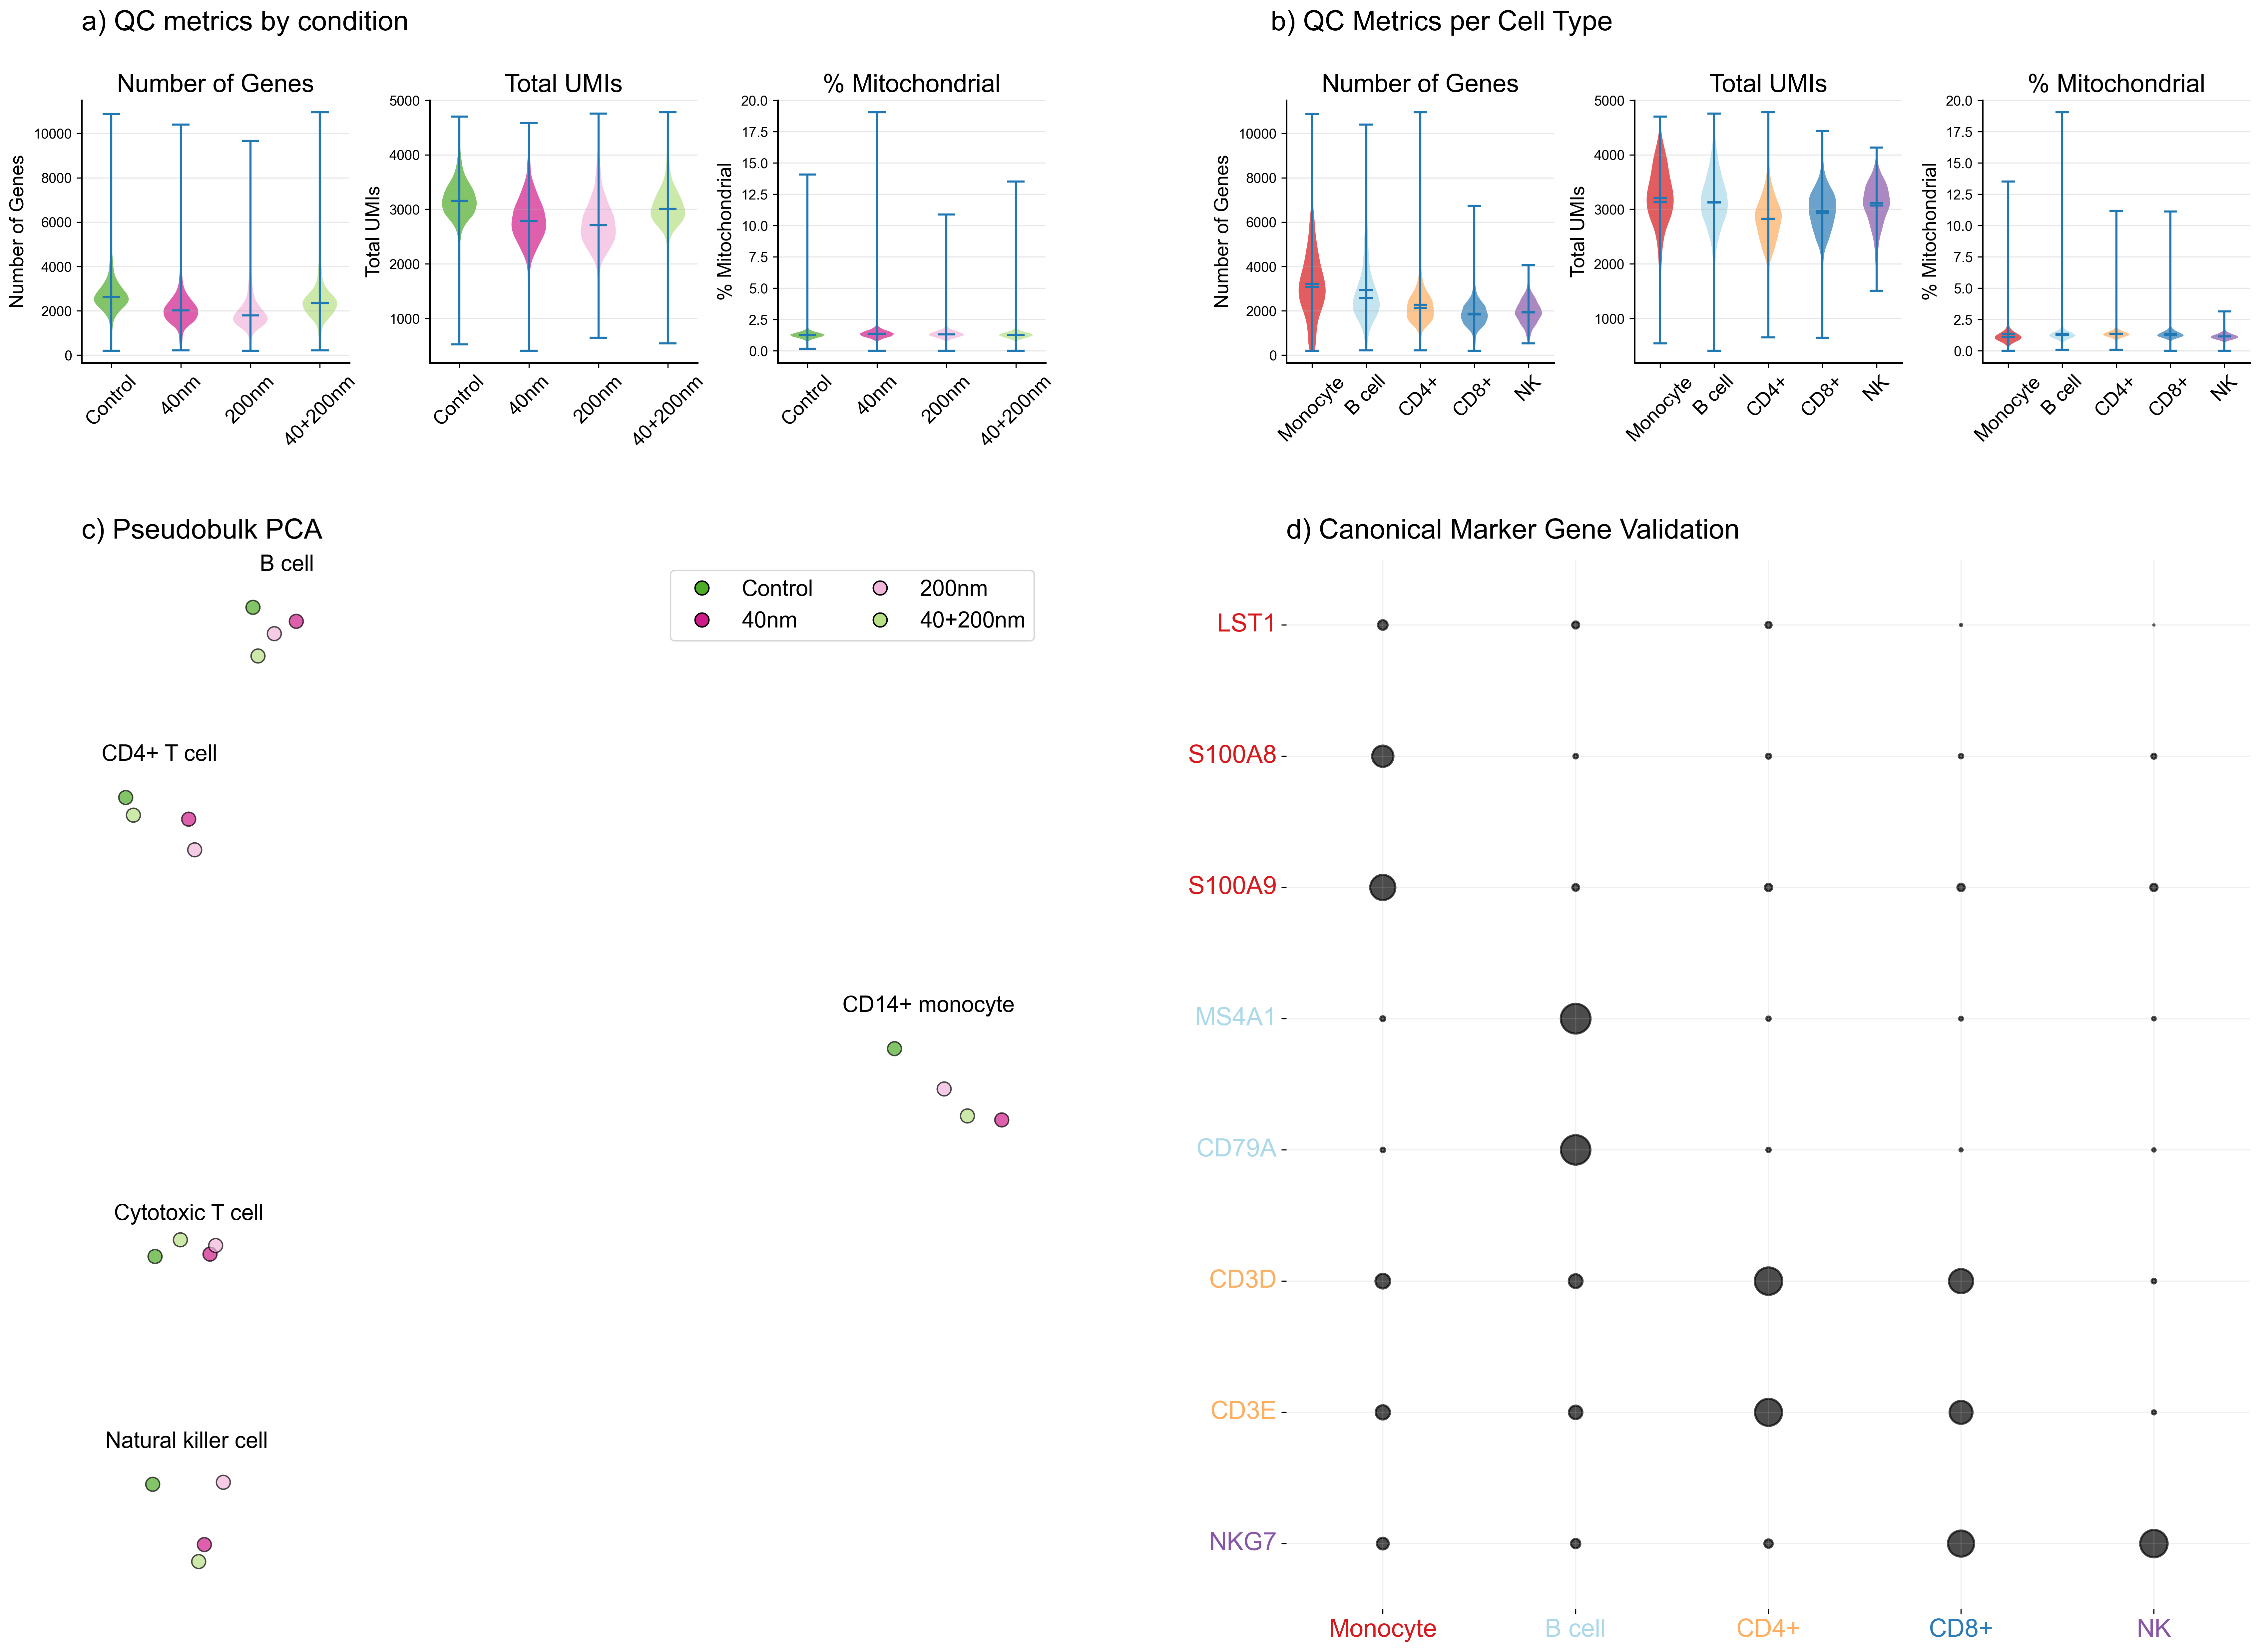

In [53]:
"""
SUPPLEMENTARY FIGURE S1: scRNA-seq quality control and robustness
- Panel S1A: Per-cell QC metrics (violin plots)
- Panel S1B: QC metrics per cell type
- Panel S1C: Pseudobulk PCA
- Panel S1D: Marker gene validation
"""
logger.info("Creating Supplementary Figure S1 (QC and robustness)...")

# Load AnnData if not already loaded
try:
    adata_qc = sc.read_h5ad('../data/merged.h5ad')
    logger.info("  Loaded data for QC analysis")
except:
    logger.error("  Could not load h5ad file for QC")
    adata_qc = None

if adata_qc is not None:
    # Detect cell type column
    ct_col = 'CoDi_dist'  # Use CoDi_dist annotation as specified
    sample_col = 'sample'
    
    # Calculate QC metrics if not present
    if 'n_genes' not in adata_qc.obs.columns:
        adata_qc.obs['n_genes'] = (adata_qc.X > 0).sum(axis=1)
    if 'n_counts' not in adata_qc.obs.columns:
        adata_qc.obs['n_counts'] = adata_qc.X.sum(axis=1)
    if 'pct_mito' not in adata_qc.obs.columns:
        mito_genes = adata_qc.var_names.str.startswith('MT-')
        if mito_genes.sum() > 0:
            adata_qc.obs['pct_mito'] = (adata_qc.X[:, mito_genes].sum(axis=1) / 
                                        adata_qc.X.sum(axis=1) * 100)
        else:
            adata_qc.obs['pct_mito'] = 0
    
    # Create figure
    figS1 = plt.figure(figsize=(28, 20))
    gsS1 = figS1.add_gridspec(2, 2, height_ratios=[1, 4],     # ← this controls the vertical split
                              hspace=0.30, wspace=0.25)
    
    # ============================================================
    # Panel S1A: Per-cell QC metrics by condition
    # ============================================================
    logger.info("a) QC metrics by condition")
    
    gs_s1a = gsS1[0, 0].subgridspec(1, 3, wspace=0.3)
    
    qc_metrics = [
        ('n_genes', 'Number of Genes'),
        ('n_counts', 'Total UMIs'),
        ('pct_mito', '% Mitochondrial')
    ]
    
    # Map sample names
    adata_qc.obs['condition'] = adata_qc.obs[sample_col].map(SAMPLE_NAMES)
    
    for idx, (metric, title) in enumerate(qc_metrics):
        ax = figS1.add_subplot(gs_s1a[0, idx])
        
        # Create violin plot
        conditions = ['Control', '40nm', '200nm', '40+200nm']
        data_by_condition = []
        for cond in conditions:
            mask = adata_qc.obs['condition'] == cond
            if mask.sum() > 0:
                data_by_condition.append(adata_qc.obs.loc[mask, metric].values)
            else:
                data_by_condition.append([])
        
        parts = ax.violinplot(data_by_condition, positions=range(len(conditions)),
                             showmeans=False, showmedians=True)
        
        for pc, cond in zip(parts['bodies'], conditions):
            pc.set_facecolor(SAMPLE_COLORS.get(cond, '#808080'))
            pc.set_alpha(0.7)
        
        ax.set_xticks(range(len(conditions)))
        ax.set_xticklabels(conditions, rotation=45, ha='center', fontsize=14)
        ax.set_ylabel(title, fontsize=14)
        ax.set_title(f'{title}', fontsize=18)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', alpha=0.3)
    
    figS1.text(0.125, 0.915, 'a) QC metrics by condition',
              fontsize=20)
    
    # ============================================================
    # Panel S1B: QC metrics per cell type
    # ============================================================
    logger.info("Panel S1B: QC metrics by cell type...")
    
    gs_s1b = gsS1[0, 1].subgridspec(1, 3, wspace=0.3)
    
    for idx, (metric, title) in enumerate(qc_metrics):
        ax = figS1.add_subplot(gs_s1b[0, idx])
        
        data_by_ct = []
        for ct in CELL_TYPE_ORDER:
            mask = adata_qc.obs[ct_col] == ct
            if mask.sum() > 0:
                data_by_ct.append(adata_qc.obs.loc[mask, metric].values)
            else:
                data_by_ct.append([])
        
        parts = ax.violinplot(data_by_ct, positions=range(len(CELL_TYPE_ORDER)),
                             showmeans=True, showmedians=True)
        
        for pc, ct in zip(parts['bodies'], CELL_TYPE_ORDER):
            pc.set_facecolor(CELL_TYPE_COLORS[ct])
            pc.set_alpha(0.7)
        
        ax.set_xticks(range(len(CELL_TYPE_ORDER)))
        ax.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=45, ha='center', fontsize=14)
        ax.set_ylabel(title, fontsize=14)
        ax.set_title(f'{title}', fontsize=18)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', alpha=0.3)
    
    figS1.text(0.55, 0.915, 'b) QC Metrics per Cell Type',
              fontsize=20)
    
    # ============================================================
    # Panel S1C: Pseudobulk PCA
    # ============================================================
    logger.info("  Panel S1C: Pseudobulk PCA")
    
    ax_s1c = figS1.add_subplot(gsS1[1, 0])
    
    # Create pseudobulk profiles
    pseudobulk_data = []
    pseudobulk_labels = []
    
    for ct in CELL_TYPE_ORDER:
        for sample in ['sample_1', 'sample_2', 'sample_3', 'sample_4']:
            mask = (adata_qc.obs[ct_col] == ct) & (adata_qc.obs[sample_col] == sample)
            if mask.sum() > 5:  # Minimum cells
                mean_expr = np.array(adata_qc.X[mask, :].mean(axis=0)).flatten()
                pseudobulk_data.append(mean_expr)
                pseudobulk_labels.append((ct, SAMPLE_NAMES[sample]))
    
    if len(pseudobulk_data) > 0:
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        
        X = np.array(pseudobulk_data)
        X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        # Plot
        for i, (ct, cond) in enumerate(pseudobulk_labels):
            ax_s1c.scatter(X_pca[i, 0], X_pca[i, 1],
                          c=[SAMPLE_COLORS.get(cond, '#808080')],
                          s=100, alpha=0.7, edgecolors='black', linewidths=1)
            if cond == 'Control': # Add only one label per cell type
                ax_s1c.text(X_pca[i, 0] + 8, X_pca[i, 1] + 8, ct, fontsize=16, ha='center', va='center')
        
        ax_s1c.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
                         fontsize=16)
        ax_s1c.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
                         fontsize=16)
    
    ax_s1c.set_title('c) Pseudobulk PCA',
                    fontsize=20, loc='left', pad=15)
    ax_s1c.spines['top'].set_visible(False)
    ax_s1c.spines['right'].set_visible(False)
    ax_s1c.spines['bottom'].set_visible(False)
    ax_s1c.spines['left'].set_visible(False)
    # Remove ticks and labels entirely
    ax_s1c.set_xticks([])
    ax_s1c.set_yticks([])
    ax_s1c.set_xlabel('')
    ax_s1c.set_ylabel('')
#     ax_s1c.grid(True, alpha=0.3)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=SAMPLE_COLORS.get(SAMPLE_NAMES[s], '#808080'),
                                  markersize=10, label=SAMPLE_NAMES[s], markeredgecolor='black')
                       for s in ['sample_4', 'sample_1', 'sample_2', 'sample_3']]
    ax_s1c.legend(handles=legend_elements, loc='best', fontsize=16, ncol=2)
    
    # ============================================================
    # Panel S1D: Marker gene validation
    # ============================================================
    logger.info("  Panel S1D: Marker gene validation...")
    
    ax_s1d = figS1.add_subplot(gsS1[1, 1])
    
    # Define canonical markers
    markers = {
        'CD14+ monocyte': ['LST1', 'S100A8', 'S100A9'],
        'B cell': ['MS4A1', 'CD79A'],
        'CD4+ T cell': ['CD3D', 'CD3E'],
        'Natural killer cell': ['NKG7']
    }
    
    # Flatten marker list
    all_markers = []
    marker_labels = []
    for ct in CELL_TYPE_ORDER:
        if ct in markers:
            for marker in markers[ct]:
                if marker in adata_qc.var_names:
                    all_markers.append(marker)
                    marker_labels.append(f"{ct}, {marker}")
    
    # Calculate mean expression per cell type
    marker_expr_matrix = []
    for marker in all_markers:
        expr_row = []
        marker_idx = adata_qc.var_names.tolist().index(marker)
        for ct in CELL_TYPE_ORDER:
            mask = adata_qc.obs[ct_col] == ct
            if mask.sum() > 0:
                mean_expr = np.array(adata_qc.X[mask, marker_idx].mean())
                pct_expr = (adata_qc.X[mask, marker_idx] > 0).sum() / mask.sum() * 100
                expr_row.append((mean_expr, pct_expr))
            else:
                expr_row.append((0, 0))
        marker_expr_matrix.append(expr_row)
    
    # Dot plot
    for i, marker_label in enumerate(marker_labels):
        for j, ct in enumerate(CELL_TYPE_ORDER):
            if i < len(marker_expr_matrix):
                mean_expr, pct_expr = marker_expr_matrix[i][j]
                size = pct_expr * 5
#                 color_intensity = min(mean_expr / 2, 1)  # Normalize
                ax_s1d.scatter(j, i, s=size, c='k',
                              alpha=0.7, edgecolors='black', linewidths=1.5)
    
    ax_s1d.set_yticks(range(len(marker_labels)))
    for i, label in enumerate(marker_labels):
        parts = label.split(', ')
        color = CELL_TYPE_COLORS.get(parts[0], '#000000')
        ax_s1d.text(-0.55, i, parts[1], va='center', ha='right', fontsize=18,
                   color=color)
    ax_s1d.set_yticklabels([])
    
    ax_s1d.set_xticks(range(len(CELL_TYPE_ORDER)))
    ax_s1d.set_xticklabels([ct for ct in CELL_TYPE_ORDER], rotation=0, ha='center', fontsize=18)
    # Then apply colors using your dictionary
    for label in ax_s1d.get_xticklabels():
        text = label.get_text()
        if text in CELL_TYPE_COLORS:
            label.set_color(CELL_TYPE_COLORS[text])
    ax_s1d.set_xticklabels([CELL_TYPE_SHORT_MAP[ct] for ct in CELL_TYPE_ORDER], rotation=0, ha='center', fontsize=18)

    ax_s1d.set_title('d) Canonical Marker Gene Validation',
                    fontsize=20, loc='left', pad=15)
    ax_s1d.set_xlim(-0.5, len(CELL_TYPE_ORDER) - 0.5)
    ax_s1d.set_ylim(-0.5, len(marker_labels) - 0.5)
    ax_s1d.grid(True, alpha=0.2)
    ax_s1d.invert_yaxis()
    ax_s1d.spines['top'].set_visible(False)
    ax_s1d.spines['right'].set_visible(False)
    ax_s1d.spines['bottom'].set_visible(False)
    ax_s1d.spines['left'].set_visible(False)
    
    plt.savefig(FIG_DIR / 'Supplementary_Figure_S1_QC.pdf', bbox_inches='tight', dpi=300)
    logger.info("✓ Supplementary Figure S1 complete\n")
else:
    logger.warning("Skipping Supplementary Figure S1 (no data)\n")

In [55]:
"""
SUPPLEMENTARY FIGURE S2: Analytical support for Figures 2 and 3
- Panel S2A: Full volcano plots with limited x-axis
"""
logger.info("Creating Supplementary Figure S2 (Analytical support)...")
gs = GridSpec(1, 1, figure=fig, hspace=0.35, height_ratios=[1],
              left=0.08, right=0.98, top=0.97, bottom=0.03)
# ============================================================
# Panel: Full Volcano Plots (5×3 grid)
# ============================================================
logger.info("  Panel 2D: Full volcano plots...")
gs_ = gs[0].subgridspec(5, 3, hspace=0.25, wspace=0.2)

for i, cell_type in enumerate(CELL_TYPE_ORDER):
    for j, condition in enumerate(samples):
        ax = fig.add_subplot(gs_[i, j])
        ax.set_xlim(-6, 6)
        sheet_name = get_sheet_name_fig2(cell_type, condition)
        
        if sheet_name in de_results:
            df = de_results[sheet_name].copy()
            df['-log10_pval'] = -np.log10(df['pvals_adj'].replace(0, 1e-300))
            sig_mask = df['pvals_adj'] < 0.05
            up_mask = (df['logfoldchanges'] > 0) & sig_mask
            down_mask = (df['logfoldchanges'] < 0) & sig_mask
            
            ax.scatter(df.loc[~sig_mask, 'logfoldchanges'], df.loc[~sig_mask, '-log10_pval'],
                      c=REG_COLORS['Not Significant'], s=2, alpha=0.3, rasterized=True)
            ax.scatter(df.loc[up_mask, 'logfoldchanges'], df.loc[up_mask, '-log10_pval'],
                      c=REG_COLORS['Upregulated'], s=3, alpha=0.6, rasterized=True)
            ax.scatter(df.loc[down_mask, 'logfoldchanges'], df.loc[down_mask, '-log10_pval'],
                      c=REG_COLORS['Downregulated'], s=3, alpha=0.6, rasterized=True)
            
            ax.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
            ax.axvline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        
        if i == 4:
            ax.set_xlabel('log2 FC', fontsize=14)
        if j == 0:
            ax.set_ylabel('-log10(p_adj)', fontsize=14)
        if i == 0:
            ax.set_title(f'{condition}', fontsize=14)
        if j == 0:
            ax.text(-0.1, 0.5, cell_type, transform=ax.transAxes,
                   rotation=90, va='center', ha='right', fontsize=14, fontweight='bold')
        
        ax.tick_params(labelsize=14)
        ax.grid(True, alpha=0.2, linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.text(0.08, 0.41, 'Full Volcano Plots - All Cell Types and Conditions',
         fontsize=20)

plt.savefig(FIG_DIR / 'Supplementary_Figure_S2_analytical_support.pdf', bbox_inches='tight')
plt.show()
logger.info("✓ Supplementary Figure S2 complete\n")

14:00:05 - INFO - Creating Supplementary Figure S2 (Analytical support)...
14:00:05 - INFO -   Panel 2D: Full volcano plots...


<Figure size 1800x1200 with 0 Axes>

14:00:05 - INFO - ✓ Supplementary Figure S2 complete



03:07:30 - INFO - Creating Supplementary Figure S3 (Full KEGG analysis)...
03:07:30 - INFO -   Processing B_cell_40 nm
03:07:30 - INFO -   Processing B_cell_200 nm
03:07:30 - INFO -   Processing B_cell_40+200 nm
03:07:30 - INFO -   Plotting 20 pathways for B cell
03:07:30 - INFO -   Processing CD4+_T_cell_40 nm
03:07:30 - INFO -   Processing CD4+_T_cell_200 nm
03:07:30 - INFO -   Processing CD4+_T_cell_40+200
03:07:30 - INFO -   Plotting 14 pathways for CD4+ T cell
03:07:30 - INFO -   Processing CD8+_T_cell_40 nm
03:07:30 - INFO -   Processing CD8+_T_cell_200 nm
03:07:30 - WARNING -   Sheet CD8+_T_cell_200 nm is empty, skipping
03:07:30 - INFO -   Processing CD8+_T_cell_40+200
03:07:30 - INFO -   Plotting 2 pathways for Cytotoxic T cell
03:07:30 - INFO -   Processing Natural_killer_cell_40 nm
03:07:30 - WARNING -   Sheet Natural_killer_cell_40 nm is empty, skipping
03:07:30 - INFO -   Processing Natural_killer_cell_200 nm
03:07:30 - INFO -   Processing Natural_killer_cell_40+200
03:07:

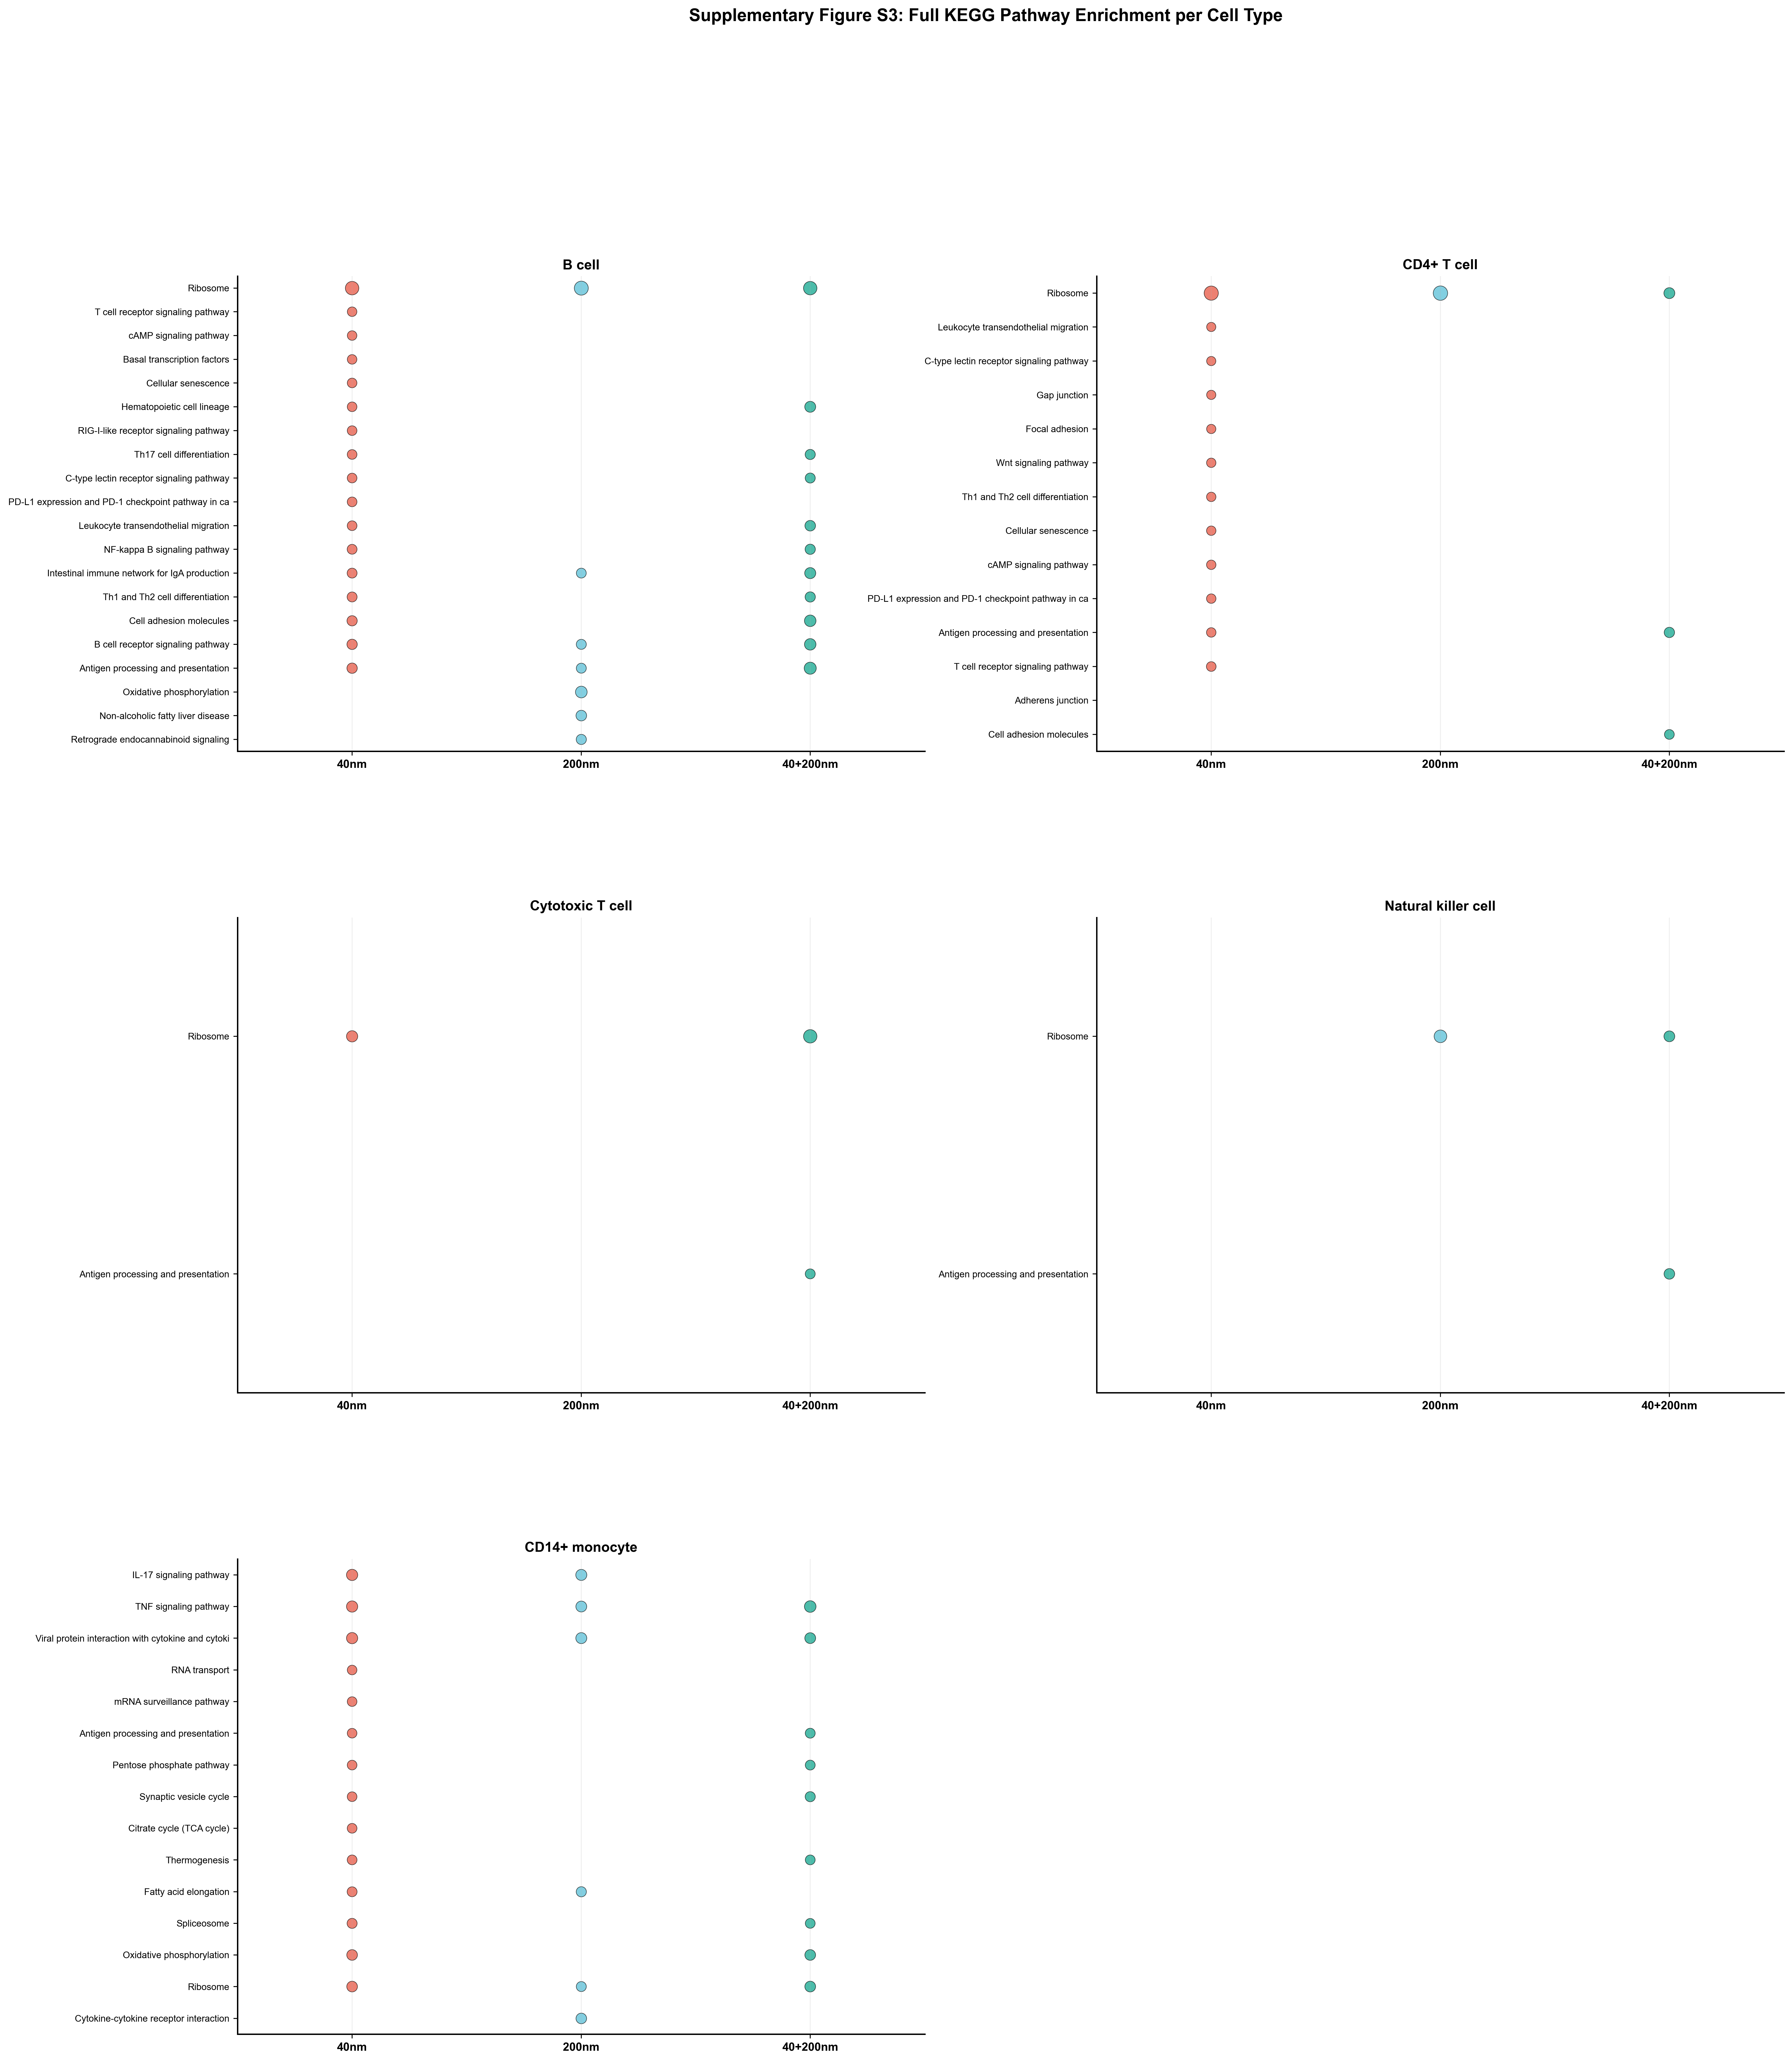

In [124]:
logger.info("Creating Supplementary Figure S3 (Full KEGG analysis)...")

# Create figure S3 with panels for each cell type
figS3 = plt.figure(figsize=(24, 28))
gsS3 = figS3.add_gridspec(3, 2, hspace=0.35, wspace=0.25)

for idx, cell_type in enumerate(CELL_TYPE_ORDER):
    row = idx // 2
    col = idx % 2
    ax = figS3.add_subplot(gsS3[row, col])

    # Collect all pathways for this cell type across conditions
    pathway_data = {}

    for condition in samples:
        sheet_name = get_gse_sheet_name(cell_type, condition)
        if sheet_name and sheet_name in gse_results:
            df = gse_results[sheet_name]
            logger.info(f"  Processing {sheet_name}")

            # Determine column name
            term_col = 'KEGG Term' if 'KEGG Term' in df.columns else 'Term'

            # Get top 20 pathways by NES
            # Skip if empty or convert NES to numeric
            if len(df) == 0:
                logger.warning(f"  Sheet {sheet_name} is empty, skipping")
                continue
            df["NES"] = pd.to_numeric(df["NES"], errors="coerce")

            top_pathways = df.nlargest(20, 'NES')
            for _, row_data in top_pathways.iterrows():
                pathway = row_data[term_col][:50]  # Truncate long names
                if pathway not in pathway_data:
                    pathway_data[pathway] = {}
                pathway_data[pathway][condition] = row_data['NES']
        else:
            logger.warning(f"  Sheet not found: {sheet_name}")

    if len(pathway_data) > 0:
        # Create dot plot
        pathways = list(pathway_data.keys())[:20]  # Top 20
        y_positions = np.arange(len(pathways))

        logger.info(f"  Plotting {len(pathways)} pathways for {cell_type}")

        # Check if we have any data to plot
        has_data = False
        for pathway in pathways:
            if any(pathway_data[pathway].get(c, 0) != 0 for c in samples):
                has_data = True
                break

        if not has_data:
            ax.text(0.5, 0.5, 'No enrichment data', ha='center', va='center',
                   fontsize=11, style='italic', transform=ax.transAxes)
            ax.axis('off')
            logger.warning(f'  No data to plot for {cell_type}')
        else:
            # Plot points and track if any were actually plotted
            points_plotted = False
            for i, pathway in enumerate(pathways):
                for j, condition in enumerate(samples):
                    nes = pathway_data[pathway].get(condition, 0)
                    if nes != 0 and not pd.isna(nes):
                        size = abs(nes) * 50
                        color = SAMPLE_COLORS[condition]
                        ax.scatter(j, i, s=size, c=[color], alpha=0.7,
                                 edgecolors='black', linewidths=0.5)
                        points_plotted = True

            if not points_plotted:
                ax.text(0.5, 0.5, 'No enrichment data', ha='center', va='center',
                       fontsize=11, style='italic', transform=ax.transAxes)
                ax.axis('off')
                logger.warning(f'  No valid NES values to plot for {cell_type}')
            else:
                ax.set_yticks(y_positions)
                ax.set_yticklabels(pathways, fontsize=8)
                ax.set_xticks(range(len(samples)))
                ax.set_xticklabels(samples, fontsize=10, fontweight='bold')
                ax.set_title(f'{cell_type}', fontsize=12, fontweight='bold')
                ax.set_xlim(-0.5, len(samples) - 0.5)
                ax.set_ylim(-0.5, len(pathways) - 0.5)
                ax.invert_yaxis()
                ax.grid(True, alpha=0.2, axis='x')
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
    else:
        ax.text(0.5, 0.5, 'No enrichment data', ha='center', va='center',
               fontsize=11, style='italic', transform=ax.transAxes)
        ax.axis('off')
        logger.warning(f"  No pathway data for {cell_type}")

figS3.suptitle('Supplementary Figure S3: Full KEGG Pathway Enrichment per Cell Type',
              fontsize=15, fontweight='bold', y=0.995)

plt.savefig(FIG_DIR / 'Supplementary_Figure_S3_full_KEGG.pdf', bbox_inches='tight')
logger.info("✓ Supplementary Figure S3 complete\n")


# ============================================================
# LATEX CAPTIONS FOR ALL FIGURES
# ============================================================

In [125]:
"""
Generate LaTeX code for figure captions
"""

latex_captions = r"""
% ============================================================
% MAIN FIGURES - LaTeX Code for Advanced Materials Manuscript
% ============================================================

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Figure_1_overview.pdf}
\caption{\textbf{Microfluidic-based scRNA-seq captures size-dependent immune responses to PSNP exposure.}
\textbf{(A)} Experimental schematic showing microfluidic chip design with blood flow and PSNP exposure conditions (Control, 40\,nm, 200\,nm, 40+200\,nm) for 24\,h, followed by scRNA-seq analysis. Panel created in BioRender.
\textbf{(B)} UMAP embedding of all immune cells colored by cell type, demonstrating successful single-cell capture and clear immune cell identities.
\textbf{(C)} UMAP embedding colored by experimental condition, showing no technical batch artifacts.
\textbf{(D)} Immune cell composition across PSNP exposure conditions, demonstrating preserved cell type distributions. This confirms that differential gene expression results are not driven by compositional shifts.}
\label{fig:overview}
\end{figure}

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Figure_2_complete.pdf}
\caption{\textbf{Size-dependent transcriptional impact of PSNP exposure across immune cell types.}
\textbf{(A)} DEG burden per cell type and experimental condition (adjusted $p < 0.05$), showing that 200\,nm PSNPs elicit stronger transcriptional responses than 40\,nm across most cell types.
\textbf{(B)} DEG density normalized to cell abundance (DEGs per 1,000 cells), revealing disproportionately high transcriptional sensitivity in monocytes and NK cells.
\textbf{(C)} Directionality of transcriptional changes, demonstrating predominant downregulation consistent with early adaptation and controlled immune response in the physiological microfluidic context.
\textbf{(D)} Full volcano plots for all cell types and conditions, visualizing the global transcriptional landscape without gene labels.}
\label{fig:deg_burden}
\end{figure}

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Figure_3_conserved_programs.pdf}
\caption{\textbf{Conserved transcriptional programs induced by PSNP exposure across immune cell types.}
\textbf{(A)} KEGG pathway enrichment heatmap showing NES scores across cell types and conditions. Pathways are grouped by functional modules: Translation \& RNA regulation (blue), Mitochondrial metabolism \& bioenergetics (green), Innate immune sensing \& inflammatory signaling (orange), and Antigen presentation \& immune communication (purple).
\textbf{(B)} Gene expression heatmap for conserved programs, showing coordinated modulation of translation/RNA regulation genes (Block 1), antigen processing genes (Block 2), and lineage markers (Block 3) across conditions and cell types.}
\label{fig:conserved_programs}
\end{figure}

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Figure_4_monocyte_remodeling.pdf}
\caption{\textbf{Size-dependent transcriptional remodeling in monocytes following PSNP exposure.}
\textbf{(A)} Three volcano plots showing differential gene expression in CD14+ monocytes for 40\,nm (left), 200\,nm (middle), and 40+200\,nm (right) conditions. Anchor genes are labeled for each condition: 40\,nm (CD36, FGL2, PDLIM4, GPX3), 200\,nm (SPP1, GPC4, AREG, ENHO), and mixed (GPC4, FGL2, MRC1L1, SIGLEC7).
\textbf{(B)} Pathway-anchored gene heatmap showing four functional modules with distinct size-dependent responses: Translation \& RNA regulation (40\,nm-specific), Vesicle trafficking (200\,nm-specific), Metabolism (200\,nm + mix), and Regulatory signaling (strongest in mix).
\textbf{(C)} Dot plot showing coherent pathway modulation across modules and conditions, demonstrating non-additive responses in the mixed exposure condition.
\textbf{(D)} Conceptual model placeholder showing size-specific monocyte responses: transcriptional tuning (40\,nm), membrane dynamics remodeling (200\,nm), and integrated metabolic-regulatory state (40+200\,nm).}
\label{fig:monocyte_remodeling}
\end{figure}

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Figure_5_adaptive_immunity.pdf}
\caption{\textbf{Adaptive immune cells display restrained and lineage-specific transcriptional responses to PSNP exposure.}
\textbf{(A)} Volcano plots for B cells (top row) and CD4+ T cells (bottom row) across three PSNP conditions (40\,nm, 200\,nm, 40+200\,nm). Labeled genes represent lineage-specific markers and receptors. B cells: MS4A7, LTA, FCER2, DOK3, TNF, HLA-C. CD4+ T cells: CCR7, IL7R, LTB, IFITM1.
\textbf{(B)} Pathway-anchored gene expression heatmap showing four modules: minimal translation/RNA regulation, antigen processing \& immune communication, adaptive immune receptor signaling, and cell adhesion/migration. Expression changes are restrained compared to innate immune responses.}
\label{fig:adaptive_immunity}
\end{figure}

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Figure_6_innate_vs_adaptive.pdf}
\caption{\textbf{Innate vs adaptive immune divergence under PSNP exposure.}
\textbf{(A)} Cross-cell-type gene response summary using dot plot format. Dot size represents percentage of cells expressing each gene, and color indicates upregulation (red) or downregulation (blue). Innate anchor genes (orange labels) show strong, condition-specific modulation in monocytes. Adaptive anchor genes (blue labels) show weaker, parallel modulation in B and CD4+ T cells with minimal cross-over.
\textbf{(B)} Schematic comparison of response logic. Left: Innate immunity (monocytes) exhibits pathway-coherent state reprogramming with non-additive behavior. Right: Adaptive immunity (B + CD4+ T) displays distributed transcriptional tuning without state transition.
\textbf{(C)} Conceptual model placeholder illustrating the immune system response hierarchy: PSNP exposure drives size-dependent state reprogramming in innate cells (monocytes) with non-additive responses, followed by transcriptional tuning in adaptive cells with preserved identity. Context: Physiological microfluidic exposure favors controlled adaptation over inflammatory activation.}
\label{fig:innate_vs_adaptive}
\end{figure}

% ============================================================
% SUPPLEMENTARY FIGURES
% ============================================================

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Supplementary_Figure_S1_QC.pdf}
\caption{\textbf{scRNA-seq quality control and technical robustness.}
\textbf{(A)} Per-cell QC metrics across experimental conditions: number of detected genes, total UMIs, and percentage of mitochondrial reads. Violin plots show no systematic shifts across conditions, confirming technical quality.
\textbf{(B)} QC metrics aggregated per cell type, demonstrating that rare populations (NK cells, CD8+ T cells) maintain high quality comparable to abundant populations.
\textbf{(C)} Pseudobulk PCA of aggregated transcriptomes, confirming absence of batch effects and showing modest separation by particle size.
\textbf{(D)} Canonical marker gene validation using dot plot format. Cell type-specific markers (Monocytes: LST1, S100A8/9; B cells: MS4A1, CD79A; T cells: CD3D/E; NK: NKG7) confirm correct cell type annotation.}
\label{fig:supp_qc}
\end{figure}

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Supplementary_Figure_S2_analytical_support.pdf}
\caption{\textbf{Analytical support for main figures.}
\textbf{(A)} Full volcano plots for all cell types and conditions with x-axis limited to [-6, 6] to visualize the complete transcriptional landscape while excluding extreme outliers.
\textbf{(B)} Top enriched pathways per cell type showing the 15 most significant KEGG terms for monocytes, B cells, and CD4+ T cells, averaged across experimental conditions.}
\label{fig:supp_analytical}
\end{figure}

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Supplementary_Figure_S3_full_KEGG.pdf}
\caption{\textbf{Complete KEGG pathway enrichment analysis per cell type.}
Dot plots showing the top 20 enriched KEGG pathways for each cell type across all PSNP exposure conditions. Dot size represents normalized enrichment score (NES) magnitude, and color indicates experimental condition. This comprehensive view complements the focused pathway selection in main figures.}
\label{fig:supp_kegg}
\end{figure}

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Supplementary_Figure_S4_MRPL41_UMAP.pdf}
\caption{\textbf{Spatial expression of RPL41 in monocytes across PSNP conditions.}
UMAP plots showing RPL41 expression (a representative ribosomal protein) in CD14+ monocytes across experimental conditions (Control, 40\,nm, 200\,nm, 40+200\,nm). Color intensity represents expression level. This visualization demonstrates the spatial organization of translation-related gene expression in response to PSNP exposure.}
\label{fig:supp_rpl41}
\end{figure}

% ============================================================
% END OF LATEX CAPTIONS
% ============================================================
"""

print("="*80)
print("LATEX CAPTIONS GENERATED")
print("="*80)
print("\nCopy the LaTeX code below for your manuscript:\n")
print(latex_captions)

# Save to file
caption_file = FIG_DIR / 'figure_captions.tex'
with open(caption_file, 'w') as f:
    f.write(latex_captions)

logger.info(f"✓ LaTeX captions saved to: {caption_file}")
print(f"\n✓ LaTeX captions also saved to: {caption_file}")
print("\n" + "="*80)
print("FIGURE GENERATION COMPLETE!")
print("="*80)
print(f"\nAll figures saved to: {FIG_DIR.absolute()}")
print("\nGenerated files:")
print("  Main Figures:")
print("    - Figure_1_overview.pdf")
print("    - Figure_2_complete.pdf")
print("    - Figure_3_conserved_programs.pdf")
print("    - Figure_4_monocyte_remodeling.pdf")
print("    - Figure_5_adaptive_immunity.pdf")
print("    - Figure_6_innate_vs_adaptive.pdf")
print("\n  Supplementary Figures:")
print("    - Supplementary_Figure_S1_QC.pdf")
print("    - Supplementary_Figure_S2_analytical_support.pdf")
print("    - Supplementary_Figure_S3_full_KEGG.pdf")
print("    - Supplementary_Figure_S4_MRPL41_UMAP.pdf")
print("\n  LaTeX Captions:")
print("    - figure_captions.tex")
print("\n" + "="*80)

03:07:34 - INFO - ✓ LaTeX captions saved to: fig/figure_captions.tex


LATEX CAPTIONS GENERATED

Copy the LaTeX code below for your manuscript:


% ============================================================
% MAIN FIGURES - LaTeX Code for Advanced Materials Manuscript
% ============================================================

\begin{figure}[!htbp]
\centering
\includegraphics[width=\textwidth]{fig/Figure_1_overview.pdf}
\caption{\textbf{Microfluidic-based scRNA-seq captures size-dependent immune responses to PSNP exposure.}
\textbf{(A)} Experimental schematic showing microfluidic chip design with blood flow and PSNP exposure conditions (Control, 40\,nm, 200\,nm, 40+200\,nm) for 24\,h, followed by scRNA-seq analysis. Panel created in BioRender.
\textbf{(B)} UMAP embedding of all immune cells colored by cell type, demonstrating successful single-cell capture and clear immune cell identities.
\textbf{(C)} UMAP embedding colored by experimental condition, showing no technical batch artifacts.
\textbf{(D)} Immune cell composition across PSNP exposure con